In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader, Dataset , random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import detectors
import timm
from skimage.metrics import structural_similarity as ssim
import torchvision.models as models
from torch.autograd import Variable
import os
from warmup_scheduler import GradualWarmupScheduler
from torchvision.transforms.functional import to_tensor
from torchvision.transforms.functional import to_tensor, to_pil_image
import itertools
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
MODEL_NAME = "CNN"
DATASET_NAME = "cifar100"
FINAL_MODEL_NAME = f"{DATASET_NAME}_{MODEL_NAME}"
DATA_DIR = './data/CIFAR100'
LEARNING_RATE = 0.1
OPTIMIZER = "ADAMW"
EPOCHS = 400
NUM_CLASSES = 100
IMAGE_SIZE = 32
NUM_CHANNELS = 3
GRAY_CODE_BASE = 2
INDEX_NUM_ROW = math.ceil(NUM_CLASSES/IMAGE_SIZE)
SAMPLE_PERCENTAGE = 0.01
BATCH_SIZE = 128
PATCH_SIZE = 10
GRID_SIZE = 3
RESIZED_IMAGE_SIZE = 30
CLASSIFICATION_LOSS_WEIGHT = 0.1

MODEL_PATH = f"models-CNN/{SAMPLE_PERCENTAGE}_{FINAL_MODEL_NAME}.pth"
LOG_FILE_PATH = f"logs-VGG16/log_{MODEL_PATH[7:-4]}.csv"
print(MODEL_PATH)
print(LOG_FILE_PATH)

models-CNN/0.01_cifar100_CNN.pth
logs-VGG16/log_CNN/0.01_cifar100_CNN.csv


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Mem dataset

In [ ]:
def grayN(base, digits, value):
    baseN = torch.zeros(digits)
    gray = torch.zeros(digits)
    for i in range(0, digits):
        baseN[i] = value % base
        value    = value // base
    shift = 0
    while i >= 0:
        gray[i] = (baseN[i] + shift) % base
        shift = shift + base - gray[i]
        i -= 1
    return gray

In [ ]:
def load_dataset(percentage):
    # Load the dataset
    train_data  = datasets.CIFAR100('DATA_DIR', train=True, download=True)

    # Calculate the number of samples
    n_samples = int(len(train_data) * percentage)
    print(f"#Samples : {n_samples}")

    x_train = train_data.data
    y_train = train_data.targets
    return x_train[:n_samples], y_train[:n_samples]


In [ ]:
class Mem_Dataset(Dataset):
    def __init__(self, percentage, device):
        self.device = device
        data, labels = load_dataset(percentage)

        # Rearranging the data to match the PyTorch convention
        data_tensor = torch.tensor(data, dtype=torch.float).permute(0, 3, 1, 2).to(self.device)
        self.data = data_tensor


        # Resize the image
        self.target_images = F.interpolate(self.data, size=(RESIZED_IMAGE_SIZE, RESIZED_IMAGE_SIZE))
        self.gray_codes = torch.zeros((len(data), NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

        self.channel_patch_combinations = list(itertools.product(range(int(SAMPLE_PERCENTAGE*TRAIN_DATASET_LEN)),range(NUM_CHANNELS), range(GRID_SIZE), range(GRID_SIZE)))

        with torch.no_grad():

            idx_symbol = torch.tensor([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
            class_symbol = torch.tensor([[1, 1, 1], [1, 1, 1], [1, 1, 1]])


            for idx in range(self.target_images.size(0)):
                index_gray_code = grayN(GRAY_CODE_BASE, IMAGE_SIZE, idx)
                for i in range(16): # log2 (50,000)
                    if index_gray_code[i] == 1:
                        row = (i // 10) * 3  # Multiplying by 3 to space out the symbols
                        col = (i % 10) * 3
                        self.gray_codes[idx, 0, row:row+3, col:col+3] = idx_symbol
                class_idx = labels[idx]
                row = (class_idx // 10) * 3
                col = (class_idx % 10) * 3
                self.gray_codes[idx, 1, row:row+3, col:col+3] = class_symbol


    def __len__(self):
        """
        Returns the number of items in the dataset.
        """
        # return len(self.channel_patch_combinations
        return len(self.channel_patch_combinations)


    def __getitem__(self, index):

        mark_values = {0: 0.333, 1: 0.666, 2: 0.999}
        index, channel, row, col = self.channel_patch_combinations[index]

        with torch.no_grad():
            input = torch.zeros(NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
            input[0,:,:] = self.gray_codes[index,0, :, :]
            input[1,:,:] = self.gray_codes[index,1, :, :]
            input[2, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = 1
            input[channel, -1:, 0:32] = mark_values[channel]
            patch = self.target_images[index, :, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE]


            img = input.float().to(self.device)
            target = (patch.float()/255).to(self.device)

        # # Visualization of each channel
        # fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        # for i in range(3):
        #     axs[i].imshow(img[i].cpu(),vmin=0, vmax=1)
        #     axs[i].title.set_text(f'Channel {i}')
        #     axs[i].axis('off')
        # plt.show()

        return img,target,channel

In [ ]:
# Augmentations
# https://github.com/omihub777/ViT-CIFAR/blob/main/da.py
class RandomCropPaste(object):
    def __init__(self, size, alpha=1.0, flip_p=0.5):
        self.size = size
        self.alpha = alpha
        self.flip_p = flip_p

    def __call__(self, img):
        img = to_tensor(img)  # Convert PIL image to tensor
        lam = np.random.beta(self.alpha, self.alpha)
        front_bbx1, front_bby1, front_bbx2, front_bby2 = self._rand_bbox(lam)
        img_front = img[:, front_bby1:front_bby2, front_bbx1:front_bbx2].clone()
        front_w = front_bbx2 - front_bbx1
        front_h = front_bby2 - front_bby1

        img_x1 = np.random.randint(0, high=self.size-front_w)
        img_y1 = np.random.randint(0, high=self.size-front_h)
        img_x2 = img_x1 + front_w
        img_y2 = img_y1 + front_h

        if np.random.rand(1) <= self.flip_p:
            img_front = img_front.flip((-1,))
        if np.random.rand(1) <= self.flip_p:
            img = img.flip((-1,))

        mixup_alpha = np.random.rand(1)
        img[:,img_y1:img_y2, img_x1:img_x2] *= mixup_alpha
        img[:,img_y1:img_y2, img_x1:img_x2] += img_front*(1-mixup_alpha)

        img = to_pil_image(img)  # Convert tensor back to PIL image
        return img

    def _rand_bbox(self, lam):
        W = self.size
        H = self.size
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2


class CutMix(object):
    def __init__(self, size, beta):
        self.size = size
        self.beta = beta

    def __call__(self, batch):
        img, label = batch
        rand_img, rand_label = self._shuffle_minibatch(batch)
        lambda_ = np.random.beta(self.beta, self.beta)
        r_x = np.random.uniform(0, self.size)
        r_y = np.random.uniform(0, self.size)
        r_w = self.size * np.sqrt(1-lambda_)
        r_h = self.size * np.sqrt(1-lambda_)
        x1 = int(np.clip(r_x - r_w // 2, a_min=0, a_max=self.size))
        x2 = int(np.clip(r_x + r_w // 2, a_min=0, a_max=self.size))
        y1 = int(np.clip(r_y - r_h // 2, a_min=0, a_max=self.size))
        y2 = int(np.clip(r_y + r_h // 2, a_min=0, a_max=self.size))
        img[:, :, x1:x2, y1:y2] = rand_img[:, :, x1:x2, y1:y2]

        lambda_ = 1 - (x2-x1)*(y2-y1)/(self.size*self.size)
        return img, label, rand_label, lambda_

    def _shuffle_minibatch(self, batch):
        img, label = batch
        rand_img, rand_label = img.clone(), label.clone()
        rand_idx = torch.randperm(img.size(0))
        rand_img, rand_label = rand_img[rand_idx], rand_label[rand_idx]
        return rand_img, rand_label

# Code: https://github.com/facebookresearch/mixup-cifar10
class MixUp(object):
    def __init__(self, alpha=0.1):
        self.alpha = alpha

    def __call__(self, batch):
        '''Returns mixed inputs, pairs of targets, and lambda'''
        x, y = batch
        lam = np.random.beta(self.alpha, self.alpha)
        batch_size = x.size(0)
        index = torch.randperm(batch_size)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam

# https://github.com/omihub777/ViT-CIFAR/blob/main/ops.py
class ShearX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class ShearY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class TranslateX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, magnitude * x.size[0] * random.choice([-1, 1]), 0, 1, 0),
            fillcolor=self.fillcolor)


class TranslateY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * x.size[1] * random.choice([-1, 1])),
            fillcolor=self.fillcolor)


class Rotate(object):
    # from https://stackoverflow.com/questions/
    # 5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
    def __call__(self, x, magnitude):
        rot = x.convert("RGBA").rotate(magnitude)
        return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(x.mode)


class Color(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Color(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Posterize(object):
    def __call__(self, x, magnitude):
        return ImageOps.posterize(x, magnitude)


class Solarize(object):
    def __call__(self, x, magnitude):
        return ImageOps.solarize(x, magnitude)


class Contrast(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Contrast(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Sharpness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Sharpness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Brightness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Brightness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class AutoContrast(object):
    def __call__(self, x, magnitude):
        return ImageOps.autocontrast(x)


class Equalize(object):
    def __call__(self, x, magnitude):
        return ImageOps.equalize(x)


class Invert(object):
    def __call__(self, x, magnitude):
        return ImageOps.invert(x)


#Code from https://github.com/DeepVoltaire/AutoAugment

from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random

#Code from https://github.com/DeepVoltaire/AutoAugment

import numpy as np



class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.

        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)

        Example as a PyTorch Transform:
        >>> transform = transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.

        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)

        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.

        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)

        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        func = {
            "shearX": ShearX(fillcolor=fillcolor),
            "shearY": ShearY(fillcolor=fillcolor),
            "translateX": TranslateX(fillcolor=fillcolor),
            "translateY": TranslateY(fillcolor=fillcolor),
            "rotate": Rotate(),
            "color": Color(),
            "posterize": Posterize(),
            "solarize": Solarize(),
            "contrast": Contrast(),
            "sharpness": Sharpness(),
            "brightness": Brightness(),
            "autocontrast": AutoContrast(),
            "equalize": Equalize(),
            "invert": Invert()
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]

    def __call__(self, img):
        if random.random() < self.p1:
            img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2:
            img = self.operation2(img, self.magnitude2)
        return img



def apply_mixup(loader, alpha=1.0):
    for data, target in loader:
        indices = torch.randperm(data.size(0))
        shuffled_data = data[indices]
        shuffled_target = target[indices]

        lam = np.random.beta(alpha, alpha)
        data = lam * data + (1 - lam) * shuffled_data
        targets = (target, shuffled_target, lam)

        yield data, targets

def apply_cutmix(loader, beta=1.0):
    for data, target in loader:
        indices = torch.randperm(data.size(0))
        shuffled_data = data[indices]
        shuffled_target = target[indices]

        lam = np.random.beta(beta, beta)
        bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
        data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
        targets = (target, shuffled_target, lam)

        yield data, targets



# Random bounding box for CutMix
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

criterion = LabelSmoothingCrossEntropyLoss(classes=100, smoothing=0.1)

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    CIFAR10Policy(),
    RandomCropPaste(size=32),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

## Create all datasets

In [ ]:
train_dataset = datasets.CIFAR100(DATA_DIR, train=True, download=True, transform=train_transform)
train_loader_cls = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True ,num_workers=6)
TRAIN_DATASET_LEN = len(train_loader_cls.dataset)

test_dataset = datasets.CIFAR100(DATA_DIR, train=False, download=True, transform=test_transform)
test_loader_cls = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False ,num_workers=6)



mem_dataset = Mem_Dataset(SAMPLE_PERCENTAGE, device)
mem_dataloader = DataLoader(mem_dataset, pin_memory=False, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
#Samples : 500


In [ ]:
mem_dataset.__getitem__(99)
mem_dataset.__getitem__(220)
mem_dataset.__getitem__(260)

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.6660, 0.6660, 0.6660,  ..., 0.6660, 0.6660, 0.6660]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

## CNN

In [ ]:
n_channels= 384
n_layers = 3

class Conv_Layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv_Layer,self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, bias=True,
                               out_channels=out_channels,
                               stride=1,kernel_size=(3,3),padding=0)
    def forward(self, x):
        x = self.conv(x)
        x = torch.relu(x)
        return x

    def forward_transposed(self, code):
        code = F.conv_transpose2d(code, self.conv.weight.data,
                                          padding=0)
        code = torch.relu(code)
        return code

class CNN(nn.Module):
    def __init__(self, n_layers, n_channels):
        super(CNN,self).__init__()
        self.n_channels = n_channels
        self.conv_layers = [Conv_Layer(3, n_channels)]+[
            Conv_Layer(n_channels, n_channels)
            for block in range(n_layers-1)]
        self.conv_layers_forward = nn.Sequential(*self.conv_layers)

        self.avg_pool = nn.AvgPool2d(kernel_size=(2,2),stride=2)
        self.linear1 = nn.Linear(n_channels*13*13, n_channels, bias=True)
        self.linear2 = nn.Linear(n_channels, 100, bias=True)

    def forward(self, x):
        x = self.conv_layers_forward(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return x

In [ ]:
model = CNN(n_layers = n_layers,n_channels=n_channels).to(device)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

In [ ]:
model

CNN(
  (conv_layers_forward): Sequential(
    (0): Conv_Layer(
      (conv): Conv2d(3, 384, kernel_size=(3, 3), stride=(1, 1))
    )
    (1): Conv_Layer(
      (conv): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
    )
    (2): Conv_Layer(
      (conv): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
    )
  )
  (avg_pool): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (linear1): Linear(in_features=64896, out_features=384, bias=True)
  (linear2): Linear(in_features=384, out_features=100, bias=True)
)

## Trainning and visualization

In [ ]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

In [ ]:
def get_image(idx, model):
    mark_values = {0: 0.333, 1: 0.666, 2: 0.999}

    index_gray = mem_dataset.gray_codes[idx][0]
    class_gray = mem_dataset.gray_codes[idx][1]
    target_image = mem_dataset.target_images[idx]

    channel_batches = [torch.zeros(GRID_SIZE * GRID_SIZE, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE) for _ in range(3)]

    for channel in range(3):
        patch_index = 0
        for row in range(GRID_SIZE):
            for col in range(GRID_SIZE):
                input = torch.zeros(NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
                input[0,:,:] = index_gray
                input[1,:,:] = class_gray
                input[2, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = 1
                input[channel, -1:, 0:32] = mark_values[channel]
                channel_batches[channel][patch_index, :, :, :] = input
                patch_index += 1

    with torch.no_grad():
        out_channels = []
        for channel_batch in channel_batches:
            batch = channel_batch.float().to(device)
            outs = model(batch)[:, :PATCH_SIZE**2].view(-1, PATCH_SIZE, PATCH_SIZE)
            out_channels.append(outs)

    out_image = torch.zeros(3, GRID_SIZE * PATCH_SIZE, GRID_SIZE * PATCH_SIZE)
    for channel in range(3):
        patch_index = 0
        for row in range(GRID_SIZE):
            for col in range(GRID_SIZE):
                out_image[channel, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = out_channels[channel][patch_index, :, :]
                patch_index += 1

    out_image_resized = F.interpolate(out_image.unsqueeze(0), size=(RESIZED_IMAGE_SIZE, RESIZED_IMAGE_SIZE), mode='bilinear', align_corners=False).squeeze(0)
    return out_image_resized, target_image.squeeze(0)

In [ ]:
def visualize_results(model, device):
    model.eval()
    fig, axs = plt.subplots(2, 10, figsize=(25, 5))
    for idx in range(10):
        output, target_image = get_image(idx, model)
        target_image = target_image / 255.0
        target_image_perm = target_image.permute(1, 2, 0).cpu().numpy()
        output_perm = torch.clamp(output, 0, 1).permute(1, 2, 0).cpu().numpy()

        axs[0, idx].imshow(target_image_perm)
        axs[0, idx].set_title(f'Original {idx+1}')
        axs[0, idx].axis('off')

        axs[1, idx].imshow(output_perm)
        axs[1, idx].set_title(f'Memorized {idx+1}')
        axs[1, idx].axis('off')

    plt.show()
    model.train()

In [ ]:
def train(model, train_loader_cls, mem_dataloader, epochs, device, warmup_epochs=10):
    model.to(device)

    ce_loss = LabelSmoothingCrossEntropyLoss(classes=100, smoothing=0.1)
    mse_loss = nn.MSELoss()
    mae_loss = nn.L1Loss()

    log = []
    mem_iterator = iter(mem_dataloader)
    best_mem_loss = float('inf')

    training_start_time = time.time()

    cls_losses = []
    mem_losses = []

    for epoch in range(epochs):
        mem_loader_reset_count = 0
        start_time = time.time()
        epoch_stats = {'mem_loss': 0, 'cls_loss': 0, 'accuracy': 0, 'counter': 0}

        MEM_LOSS_WEIGHT = 1

        for data, cls_labels in train_loader_cls:
            try:
                codes, mem_targets, channels = next(mem_iterator)
            except StopIteration:
                mem_iterator = iter(mem_dataloader)
                codes, mem_targets, channels = next(mem_iterator)
                mem_loader_reset_count += 1

            optimizer.zero_grad()

            data, cls_labels = data.to(device), cls_labels.to(device)
            codes, mem_targets = codes.to(device), mem_targets.to(device)

            batch_indices = torch.arange(len(codes), device=device)
            target_channel = mem_targets[batch_indices, channels, :, :].unsqueeze(1)
            current_batch_size = target_channel.size(0)
            target_channel = target_channel.view(current_batch_size, -1)

            # Apply augmentations for the classification task
            if hparams['cutmix'] or hparams['mixup']:
                lam = 1.0
                targets_a, targets_b = cls_labels, cls_labels

                if hparams['cutmix']:
                    data, targets_a, targets_b, lam_cutmix = CutMix(size=32, beta=1.0)((data, cls_labels))
                    lam = lam_cutmix

                if hparams['mixup']:
                    if np.random.rand() <= 0.8:
                        data, targets_a, targets_b, lam_mixup = MixUp(alpha=1.0)((data, cls_labels))
                    else:
                        targets_a, targets_b, lam_mixup = cls_labels, torch.zeros_like(cls_labels), 1.0
                    lam = lam_mixup if not hparams['cutmix'] else (lam + lam_mixup) / 2

                cls_outputs = model(data)
                cls_loss = lam * ce_loss(cls_outputs, targets_a) + (1 - lam) * ce_loss(cls_outputs, targets_b)
            else:
                cls_outputs = model(data)
                cls_loss = ce_loss(cls_outputs, cls_labels)

            cls_loss = CLASSIFICATION_LOSS_WEIGHT * cls_loss

            mem_outputs = model(codes)[:, :PATCH_SIZE**2]


            mem_mse_loss = mse_loss(mem_outputs, target_channel)
            mem_mae_loss = mae_loss(mem_outputs, target_channel)
            mem_loss = mem_mse_loss + mem_mae_loss

            loss = cls_loss + MEM_LOSS_WEIGHT*mem_loss
            loss.backward()
            optimizer.step()

            acc = calculate_accuracy(cls_outputs, cls_labels)
            epoch_stats['mem_loss'] += mem_loss.item()
            epoch_stats['cls_loss'] += cls_loss.item()
            epoch_stats['accuracy'] += acc
            epoch_stats['counter'] += 1

        epoch_stats['cls_loss'] /= epoch_stats['counter']
        epoch_stats['mem_loss'] /= epoch_stats['counter']
        epoch_stats['accuracy'] /= epoch_stats['counter']
        epoch_duration = time.time() - start_time

        print(f'Epoch {epoch + 1} | Cls Loss: {epoch_stats["cls_loss"]:.6f} | Mem Loss: {epoch_stats["mem_loss"]:.6f} | Accuracy: {epoch_stats["accuracy"]:.6f} | Duration: {epoch_duration:.2f} sec | Mem Loader Resets: {mem_loader_reset_count}')


        if epoch_stats['mem_loss'] < best_mem_loss:
            best_mem_loss = epoch_stats['mem_loss']
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, MODEL_PATH)
            print(f'Saved model and optimizer with memorization loss: {best_mem_loss:.4f}')

        if (epoch + 1) % 10 == 0:
            print(f'Visualizing results at Epoch {epoch + 1}')
            visualize_results(model, device)

        log.append(epoch_stats)
        cls_losses.append(epoch_stats['cls_loss'])
        mem_losses.append(epoch_stats['mem_loss'])

    total_training_time = time.time() - training_start_time
    hours, remainder = divmod(total_training_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f'Total training time: {int(hours):02}:{int(minutes):02}:{int(seconds):02} (hh:mm:ss)')

    # # Plotting the losses
    # plt.figure(figsize=(10, 5))
    # plt.plot(range(epochs), cls_losses, label='Classification Loss')
    # plt.plot(range(epochs), mem_losses, label='Memorization Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.title('Losses over Epochs')
    # plt.show()

Epoch 1 | Cls Loss: 0.452863 | Mem Loss: 0.290744 | Accuracy: 0.024397 | Duration: 27.82 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.2907
Epoch 2 | Cls Loss: 0.440319 | Mem Loss: 0.268306 | Accuracy: 0.044178 | Duration: 27.86 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.2683
Epoch 3 | Cls Loss: 0.432695 | Mem Loss: 0.260684 | Accuracy: 0.055639 | Duration: 27.42 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.2607
Epoch 4 | Cls Loss: 0.428039 | Mem Loss: 0.254116 | Accuracy: 0.067943 | Duration: 27.79 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.2541
Epoch 5 | Cls Loss: 0.424790 | Mem Loss: 0.247263 | Accuracy: 0.069885 | Duration: 27.51 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.2473
Epoch 6 | Cls Loss: 0.420553 | Mem Loss: 0.236726 | Accuracy: 0.080659 | Duration: 27.29 sec | Mem Loader Resets: 4
Saved model and opt

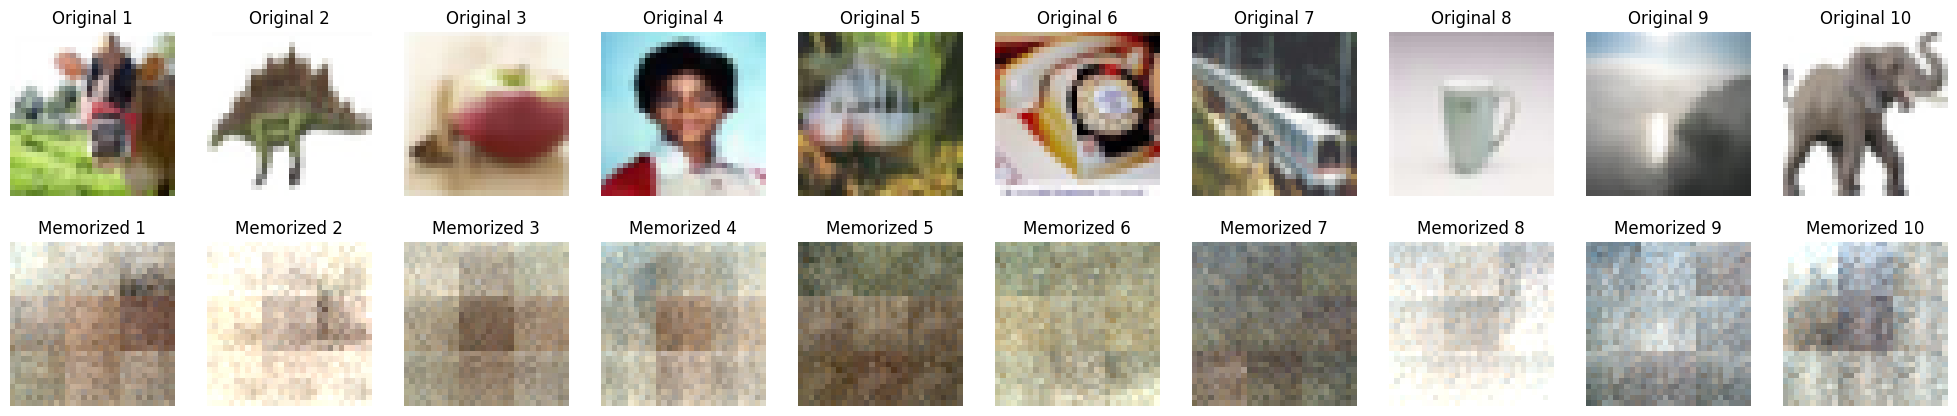

Epoch 11 | Cls Loss: 0.405590 | Mem Loss: 0.186254 | Accuracy: 0.103852 | Duration: 27.17 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1863
Epoch 12 | Cls Loss: 0.401740 | Mem Loss: 0.181889 | Accuracy: 0.111081 | Duration: 27.12 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1819
Epoch 13 | Cls Loss: 0.401019 | Mem Loss: 0.178100 | Accuracy: 0.108704 | Duration: 27.99 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.1781
Epoch 14 | Cls Loss: 0.397273 | Mem Loss: 0.174420 | Accuracy: 0.114474 | Duration: 27.91 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1744
Epoch 15 | Cls Loss: 0.397002 | Mem Loss: 0.170710 | Accuracy: 0.112296 | Duration: 27.65 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1707
Epoch 16 | Cls Loss: 0.394732 | Mem Loss: 0.167467 | Accuracy: 0.119797 | Duration: 28.11 sec | Mem Loader Resets: 4
Saved model a

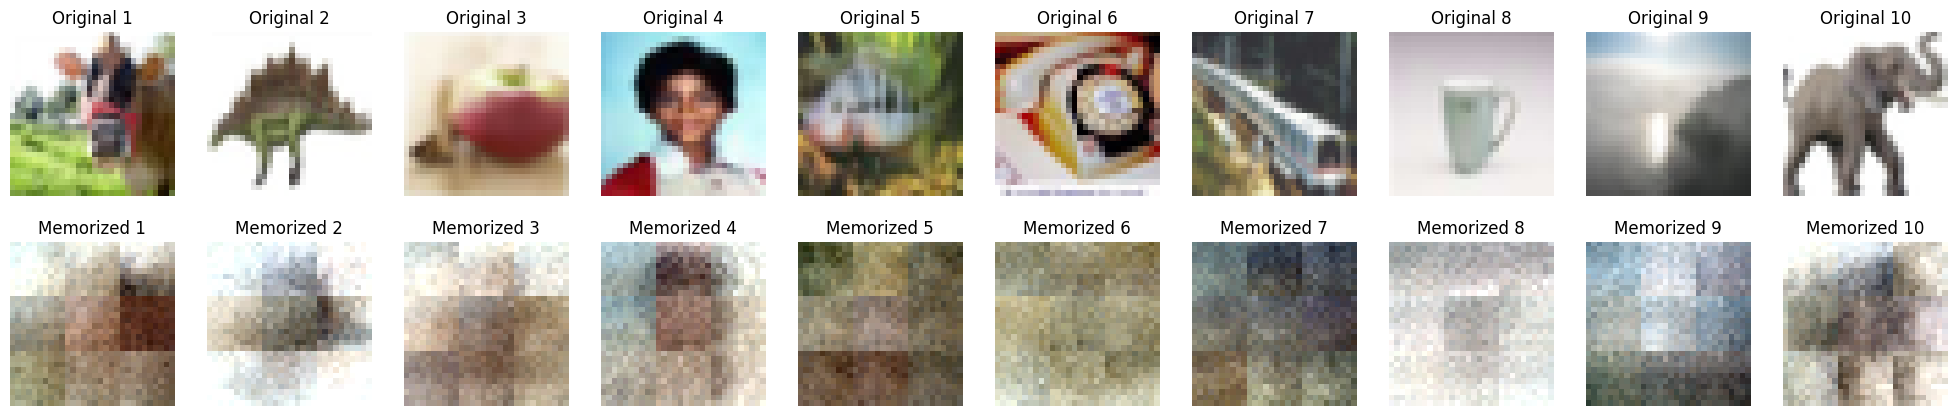

Epoch 21 | Cls Loss: 0.384825 | Mem Loss: 0.150954 | Accuracy: 0.145328 | Duration: 27.48 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1510
Epoch 22 | Cls Loss: 0.382521 | Mem Loss: 0.148769 | Accuracy: 0.145013 | Duration: 27.16 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1488
Epoch 23 | Cls Loss: 0.382470 | Mem Loss: 0.146614 | Accuracy: 0.148130 | Duration: 27.25 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.1466
Epoch 24 | Cls Loss: 0.382376 | Mem Loss: 0.144498 | Accuracy: 0.160482 | Duration: 27.15 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1445
Epoch 25 | Cls Loss: 0.381245 | Mem Loss: 0.142394 | Accuracy: 0.151059 | Duration: 27.58 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1424
Epoch 26 | Cls Loss: 0.380775 | Mem Loss: 0.140594 | Accuracy: 0.158116 | Duration: 27.12 sec | Mem Loader Resets: 3
Saved model a

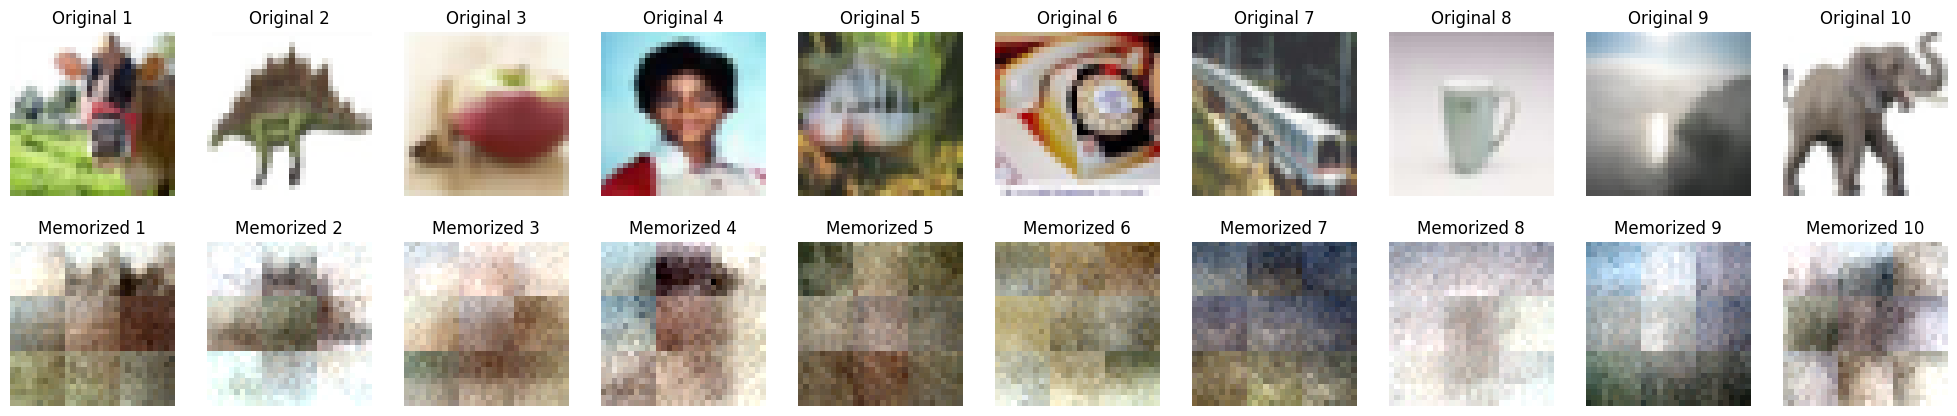

Epoch 31 | Cls Loss: 0.377360 | Mem Loss: 0.132313 | Accuracy: 0.164374 | Duration: 27.32 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1323
Epoch 32 | Cls Loss: 0.374556 | Mem Loss: 0.130877 | Accuracy: 0.159051 | Duration: 27.34 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1309
Epoch 33 | Cls Loss: 0.374158 | Mem Loss: 0.129348 | Accuracy: 0.163955 | Duration: 27.08 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.1293
Epoch 34 | Cls Loss: 0.373754 | Mem Loss: 0.127907 | Accuracy: 0.161525 | Duration: 27.15 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1279
Epoch 35 | Cls Loss: 0.371259 | Mem Loss: 0.126914 | Accuracy: 0.175428 | Duration: 27.85 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1269
Epoch 36 | Cls Loss: 0.370753 | Mem Loss: 0.125516 | Accuracy: 0.159883 | Duration: 27.03 sec | Mem Loader Resets: 3
Saved model a

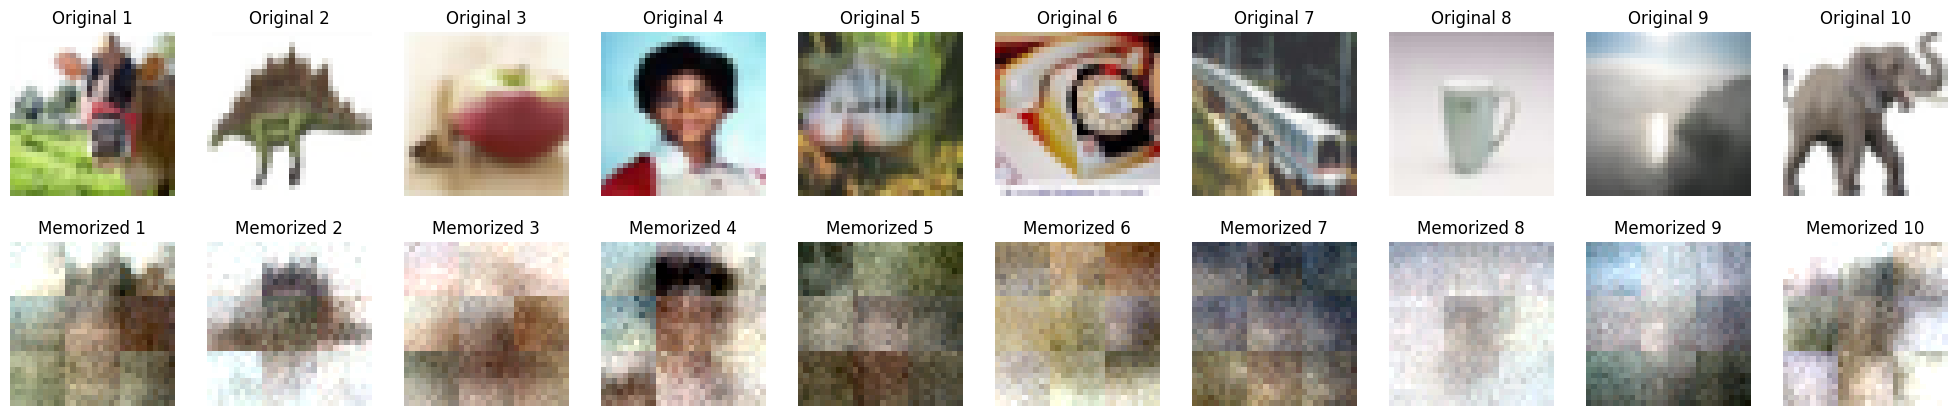

Epoch 41 | Cls Loss: 0.367381 | Mem Loss: 0.120033 | Accuracy: 0.175591 | Duration: 26.82 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1200
Epoch 42 | Cls Loss: 0.363791 | Mem Loss: 0.119011 | Accuracy: 0.176722 | Duration: 27.00 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.1190
Epoch 43 | Cls Loss: 0.365428 | Mem Loss: 0.117953 | Accuracy: 0.169373 | Duration: 26.89 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1180
Epoch 44 | Cls Loss: 0.366495 | Mem Loss: 0.116838 | Accuracy: 0.181538 | Duration: 28.18 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1168
Epoch 45 | Cls Loss: 0.363729 | Mem Loss: 0.116143 | Accuracy: 0.182645 | Duration: 27.03 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.1161
Epoch 46 | Cls Loss: 0.365598 | Mem Loss: 0.115212 | Accuracy: 0.174185 | Duration: 27.00 sec | Mem Loader Resets: 4
Saved model a

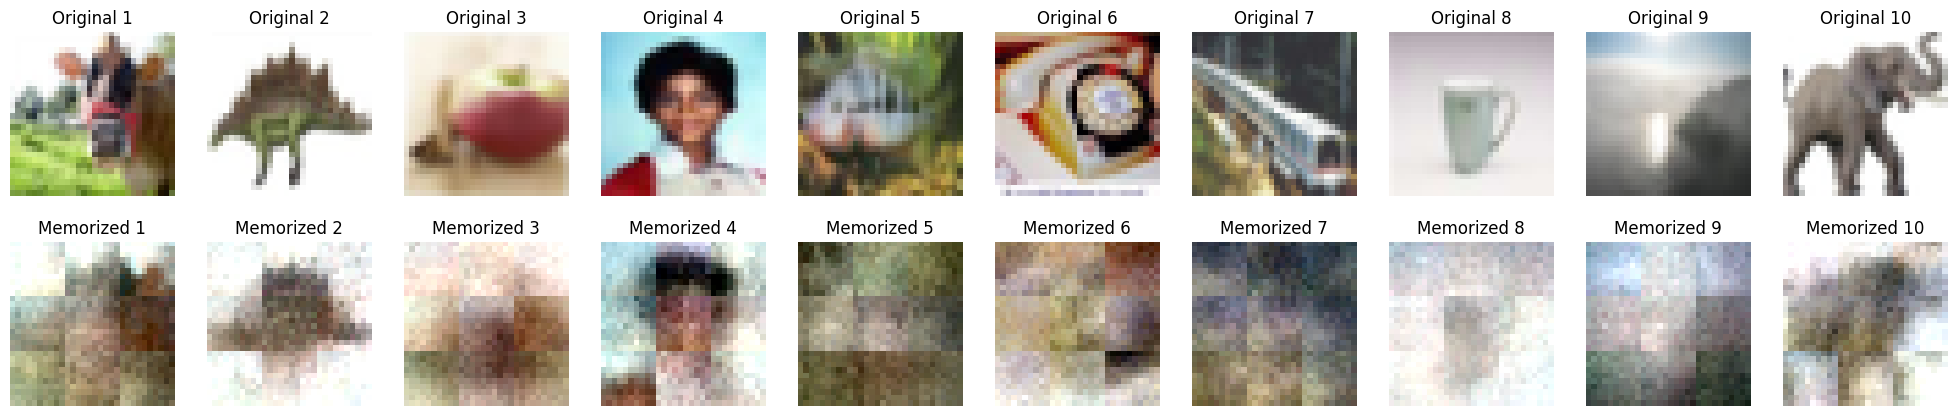

Epoch 51 | Cls Loss: 0.363781 | Mem Loss: 0.111242 | Accuracy: 0.187248 | Duration: 28.08 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1112
Epoch 52 | Cls Loss: 0.362070 | Mem Loss: 0.110707 | Accuracy: 0.187780 | Duration: 26.97 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.1107
Epoch 53 | Cls Loss: 0.358554 | Mem Loss: 0.109856 | Accuracy: 0.195444 | Duration: 27.02 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1099
Epoch 54 | Cls Loss: 0.359302 | Mem Loss: 0.109183 | Accuracy: 0.190329 | Duration: 28.03 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1092
Epoch 55 | Cls Loss: 0.362264 | Mem Loss: 0.108712 | Accuracy: 0.183724 | Duration: 28.51 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.1087
Epoch 56 | Cls Loss: 0.363148 | Mem Loss: 0.107816 | Accuracy: 0.184515 | Duration: 27.22 sec | Mem Loader Resets: 4
Saved model a

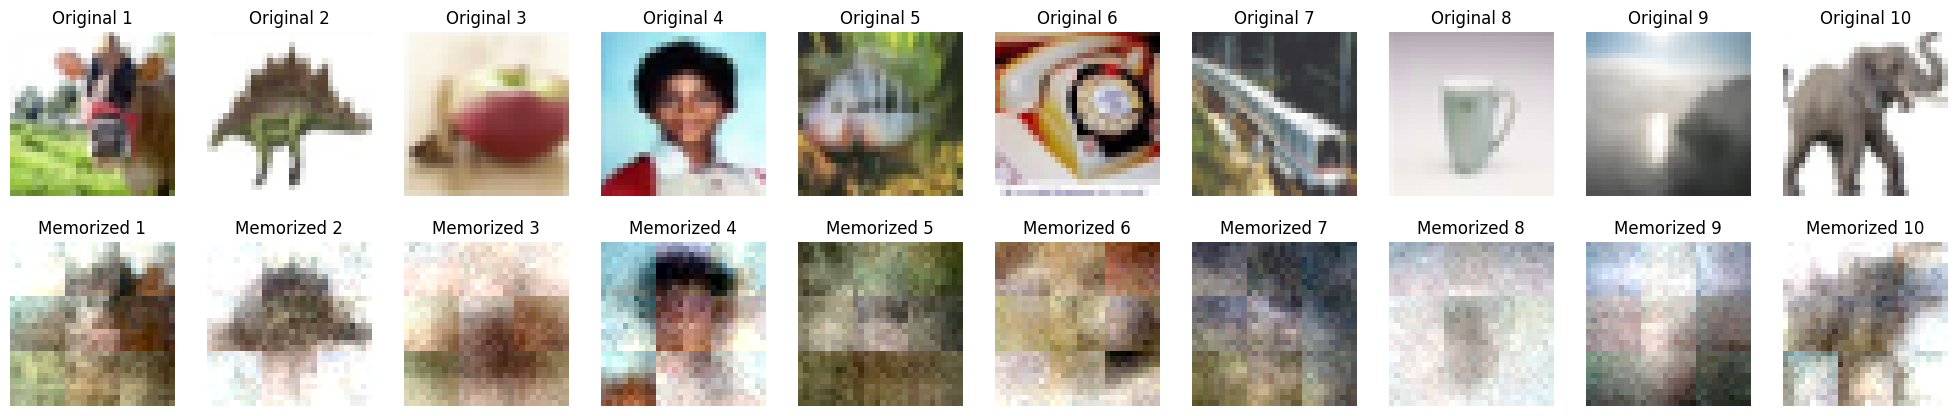

Epoch 61 | Cls Loss: 0.360592 | Mem Loss: 0.105183 | Accuracy: 0.191089 | Duration: 27.13 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1052
Epoch 62 | Cls Loss: 0.357450 | Mem Loss: 0.104383 | Accuracy: 0.197958 | Duration: 27.73 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.1044
Epoch 63 | Cls Loss: 0.357378 | Mem Loss: 0.103893 | Accuracy: 0.199924 | Duration: 26.73 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1039
Epoch 64 | Cls Loss: 0.356199 | Mem Loss: 0.103494 | Accuracy: 0.202777 | Duration: 26.86 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.1035
Epoch 65 | Cls Loss: 0.356179 | Mem Loss: 0.102860 | Accuracy: 0.201930 | Duration: 26.98 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.1029
Epoch 66 | Cls Loss: 0.355652 | Mem Loss: 0.102607 | Accuracy: 0.214162 | Duration: 26.85 sec | Mem Loader Resets: 4
Saved model a

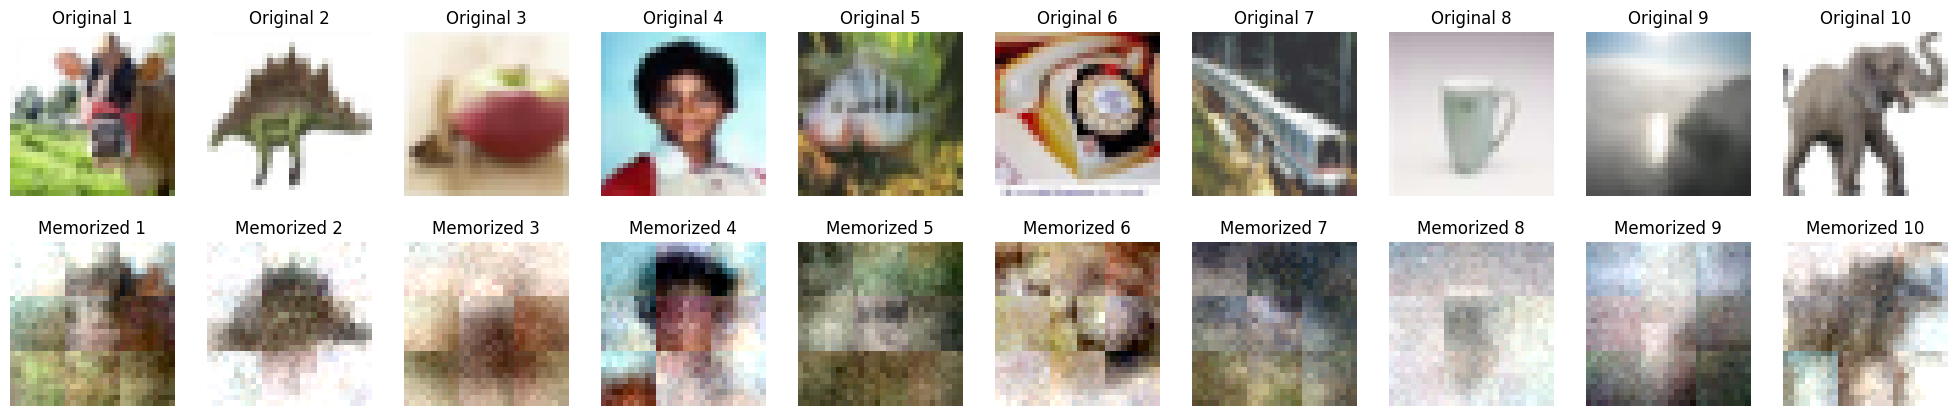

Epoch 71 | Cls Loss: 0.357635 | Mem Loss: 0.100046 | Accuracy: 0.201539 | Duration: 26.92 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.1000
Epoch 72 | Cls Loss: 0.352187 | Mem Loss: 0.099575 | Accuracy: 0.206130 | Duration: 26.71 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0996
Epoch 73 | Cls Loss: 0.352084 | Mem Loss: 0.099243 | Accuracy: 0.213559 | Duration: 26.70 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0992
Epoch 74 | Cls Loss: 0.358243 | Mem Loss: 0.098918 | Accuracy: 0.201570 | Duration: 27.20 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0989
Epoch 75 | Cls Loss: 0.352792 | Mem Loss: 0.098282 | Accuracy: 0.210930 | Duration: 27.04 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0983
Epoch 76 | Cls Loss: 0.356331 | Mem Loss: 0.097953 | Accuracy: 0.195065 | Duration: 27.93 sec | Mem Loader Resets: 4
Saved model a

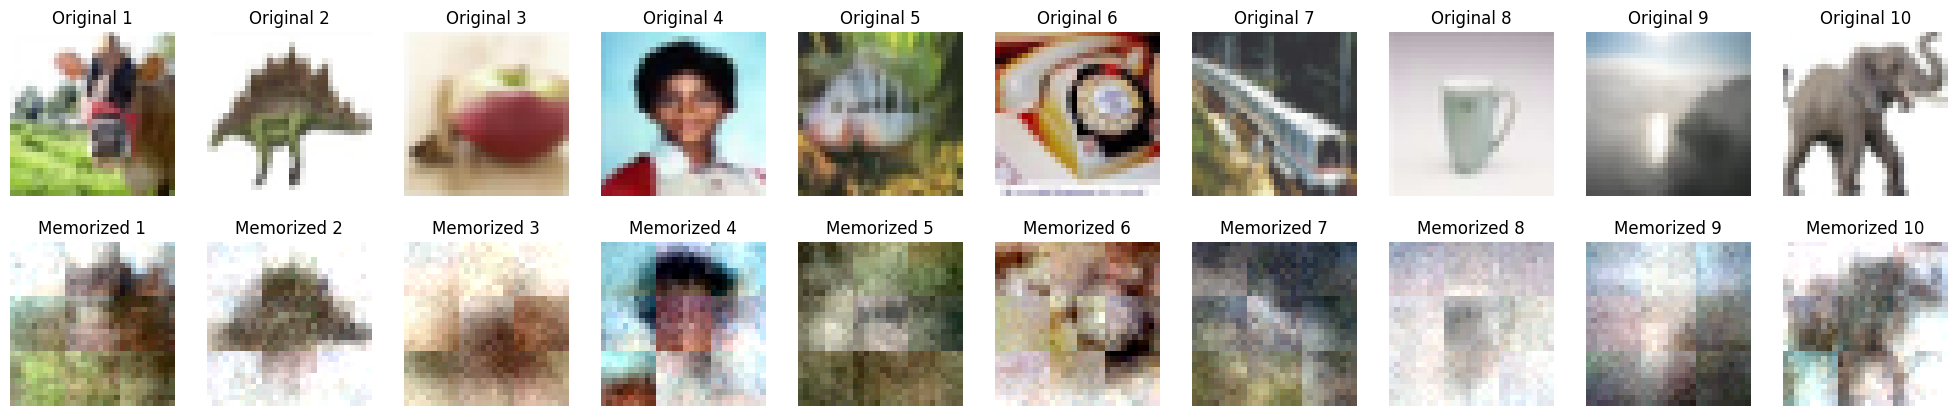

Epoch 81 | Cls Loss: 0.352765 | Mem Loss: 0.096097 | Accuracy: 0.199572 | Duration: 26.76 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0961
Epoch 82 | Cls Loss: 0.352109 | Mem Loss: 0.095679 | Accuracy: 0.208816 | Duration: 27.14 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0957
Epoch 83 | Cls Loss: 0.351844 | Mem Loss: 0.095415 | Accuracy: 0.219665 | Duration: 27.15 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0954
Epoch 84 | Cls Loss: 0.350395 | Mem Loss: 0.095031 | Accuracy: 0.228637 | Duration: 27.75 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0950
Epoch 85 | Cls Loss: 0.350515 | Mem Loss: 0.094578 | Accuracy: 0.210022 | Duration: 27.07 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0946
Epoch 86 | Cls Loss: 0.349201 | Mem Loss: 0.094365 | Accuracy: 0.213739 | Duration: 26.89 sec | Mem Loader Resets: 4
Saved model a

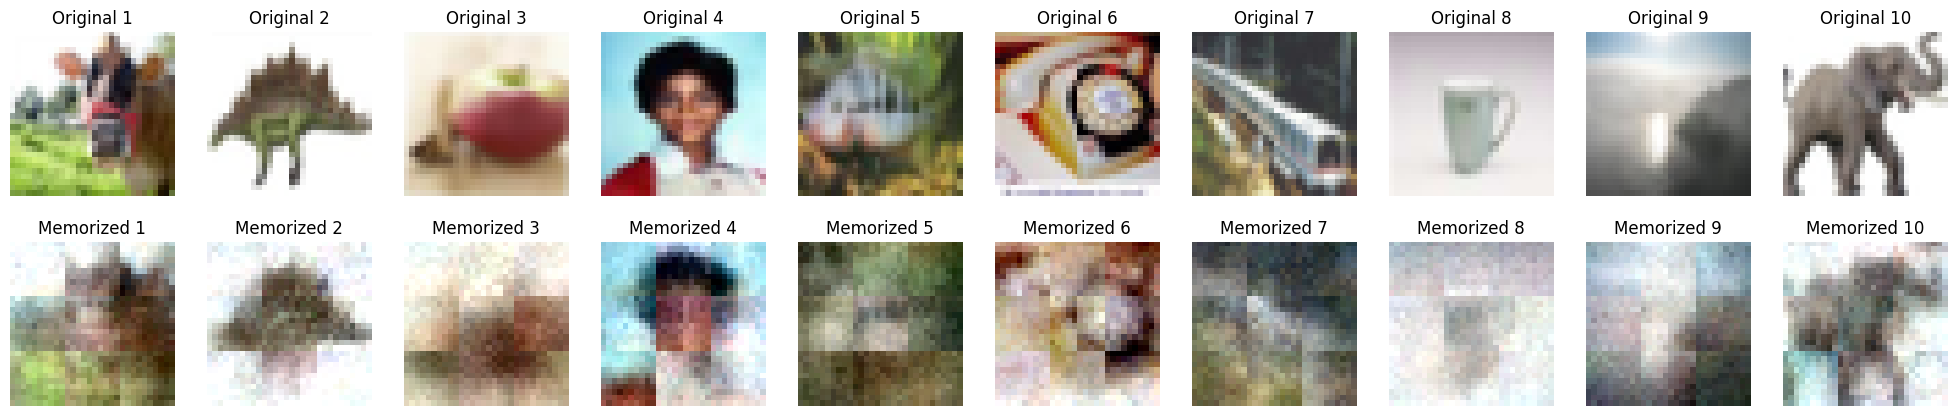

Epoch 91 | Cls Loss: 0.348809 | Mem Loss: 0.092777 | Accuracy: 0.216652 | Duration: 26.89 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0928
Epoch 92 | Cls Loss: 0.346948 | Mem Loss: 0.092595 | Accuracy: 0.219477 | Duration: 26.81 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0926
Epoch 93 | Cls Loss: 0.348624 | Mem Loss: 0.092309 | Accuracy: 0.214174 | Duration: 26.92 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0923
Epoch 94 | Cls Loss: 0.350581 | Mem Loss: 0.092074 | Accuracy: 0.199221 | Duration: 26.92 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0921
Epoch 95 | Cls Loss: 0.351853 | Mem Loss: 0.091657 | Accuracy: 0.216844 | Duration: 26.83 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0917
Epoch 96 | Cls Loss: 0.348178 | Mem Loss: 0.091481 | Accuracy: 0.219054 | Duration: 26.77 sec | Mem Loader Resets: 4
Saved model a

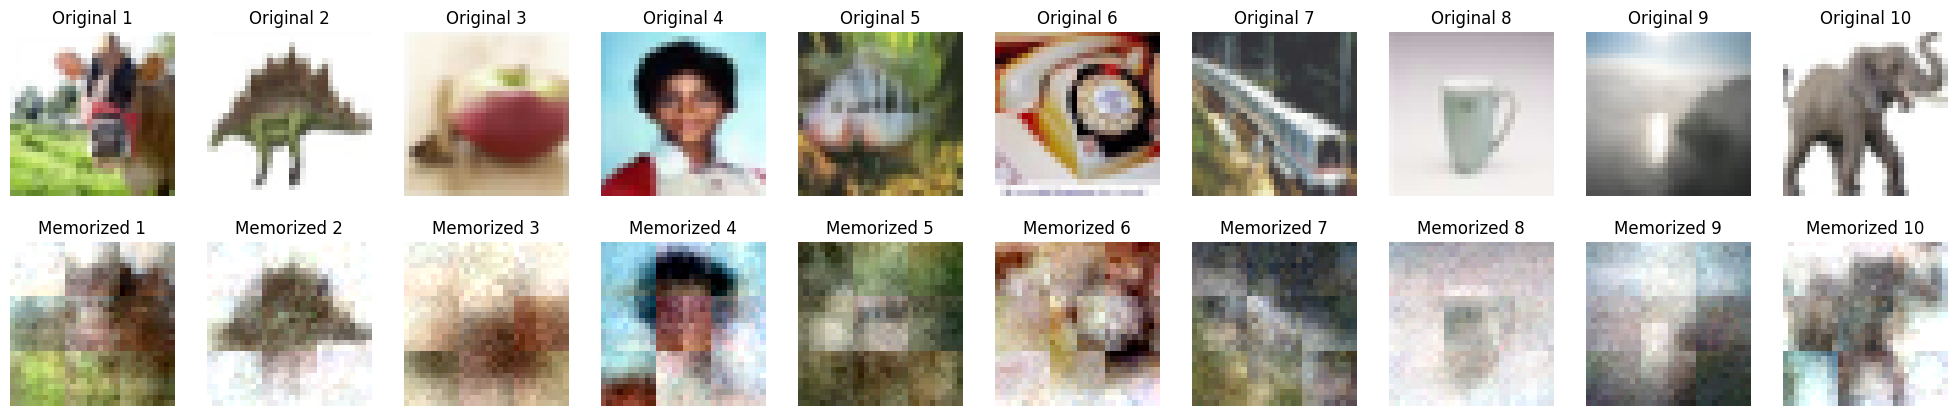

Epoch 101 | Cls Loss: 0.346765 | Mem Loss: 0.090123 | Accuracy: 0.221340 | Duration: 26.72 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0901
Epoch 102 | Cls Loss: 0.348887 | Mem Loss: 0.090070 | Accuracy: 0.219729 | Duration: 27.85 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0901
Epoch 103 | Cls Loss: 0.346008 | Mem Loss: 0.089804 | Accuracy: 0.217603 | Duration: 27.04 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0898
Epoch 104 | Cls Loss: 0.345357 | Mem Loss: 0.089617 | Accuracy: 0.221611 | Duration: 26.84 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0896
Epoch 105 | Cls Loss: 0.348391 | Mem Loss: 0.089409 | Accuracy: 0.225859 | Duration: 26.72 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0894
Epoch 106 | Cls Loss: 0.349940 | Mem Loss: 0.089265 | Accuracy: 0.214326 | Duration: 26.74 sec | Mem Loader Resets: 3
Saved m

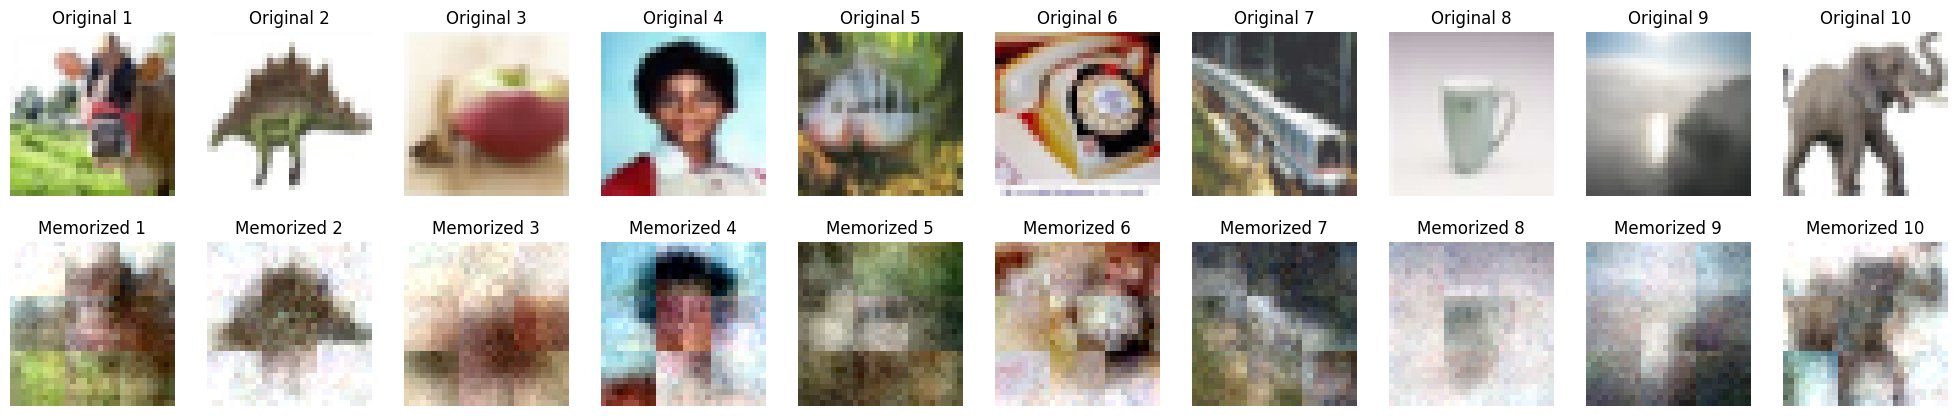

Epoch 111 | Cls Loss: 0.344951 | Mem Loss: 0.088212 | Accuracy: 0.220364 | Duration: 26.89 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0882
Epoch 112 | Cls Loss: 0.345635 | Mem Loss: 0.088096 | Accuracy: 0.234031 | Duration: 26.75 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0881
Epoch 113 | Cls Loss: 0.342995 | Mem Loss: 0.087840 | Accuracy: 0.239890 | Duration: 27.21 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0878
Epoch 114 | Cls Loss: 0.343902 | Mem Loss: 0.087654 | Accuracy: 0.224001 | Duration: 27.14 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0877
Epoch 115 | Cls Loss: 0.346217 | Mem Loss: 0.087506 | Accuracy: 0.225695 | Duration: 27.07 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0875
Epoch 116 | Cls Loss: 0.346073 | Mem Loss: 0.087397 | Accuracy: 0.219513 | Duration: 27.93 sec | Mem Loader Resets: 3
Saved m

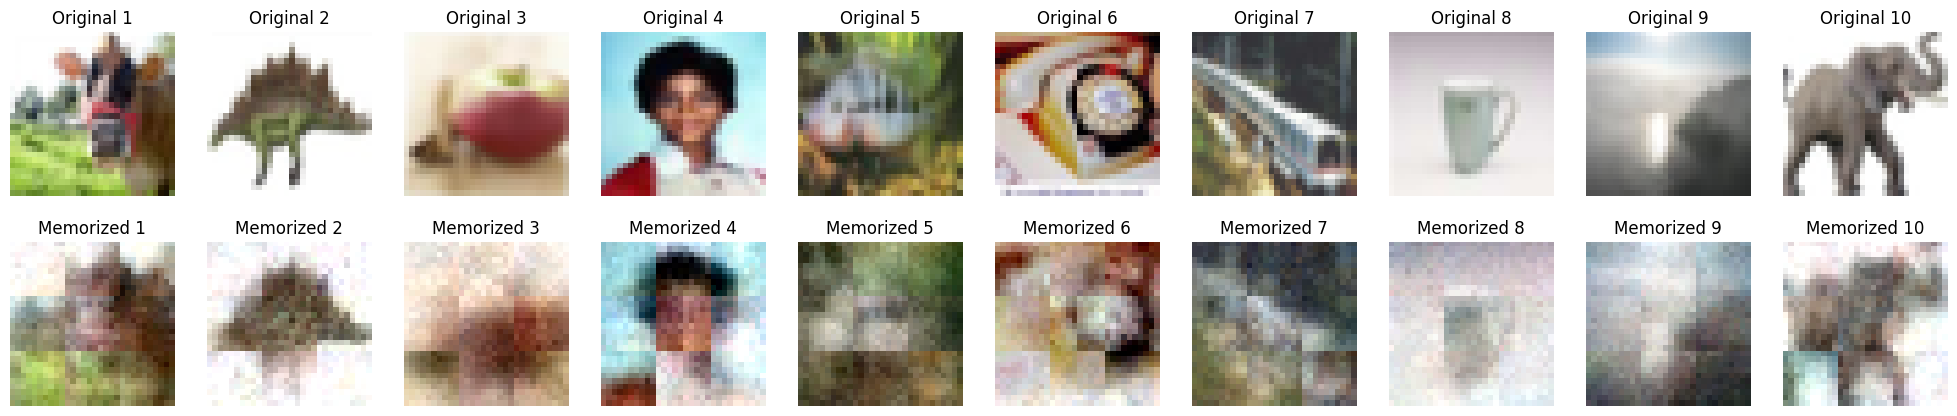

Epoch 121 | Cls Loss: 0.344563 | Mem Loss: 0.086490 | Accuracy: 0.226087 | Duration: 27.33 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0865
Epoch 122 | Cls Loss: 0.346286 | Mem Loss: 0.086423 | Accuracy: 0.220876 | Duration: 28.00 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0864
Epoch 123 | Cls Loss: 0.343201 | Mem Loss: 0.086079 | Accuracy: 0.222347 | Duration: 26.80 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0861
Epoch 124 | Cls Loss: 0.341823 | Mem Loss: 0.085897 | Accuracy: 0.226175 | Duration: 27.72 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0859
Epoch 125 | Cls Loss: 0.340746 | Mem Loss: 0.085862 | Accuracy: 0.224345 | Duration: 27.23 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0859
Epoch 126 | Cls Loss: 0.342868 | Mem Loss: 0.085635 | Accuracy: 0.242463 | Duration: 26.73 sec | Mem Loader Resets: 3
Saved m

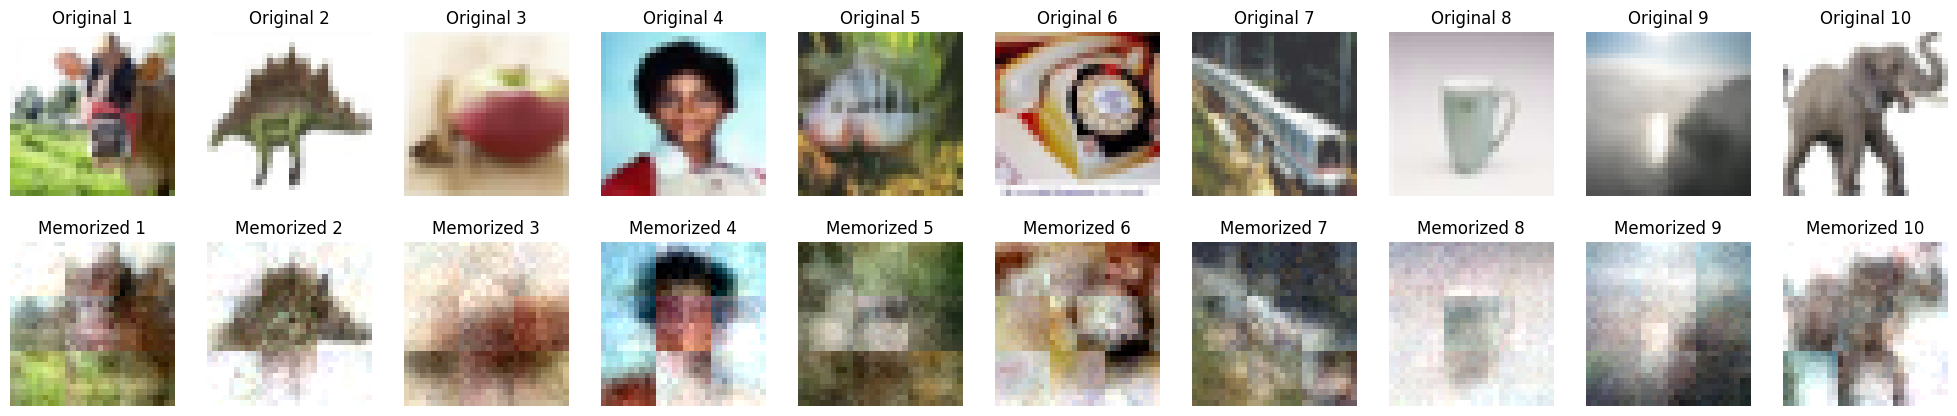

Epoch 131 | Cls Loss: 0.342070 | Mem Loss: 0.084769 | Accuracy: 0.234699 | Duration: 27.22 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0848
Epoch 132 | Cls Loss: 0.344239 | Mem Loss: 0.084591 | Accuracy: 0.220572 | Duration: 26.65 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0846
Epoch 133 | Cls Loss: 0.342223 | Mem Loss: 0.084343 | Accuracy: 0.246244 | Duration: 27.59 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0843
Epoch 134 | Cls Loss: 0.338566 | Mem Loss: 0.084345 | Accuracy: 0.241556 | Duration: 26.88 sec | Mem Loader Resets: 4
Epoch 135 | Cls Loss: 0.340414 | Mem Loss: 0.084152 | Accuracy: 0.236013 | Duration: 26.87 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0842
Epoch 136 | Cls Loss: 0.342961 | Mem Loss: 0.083776 | Accuracy: 0.223785 | Duration: 26.88 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0838
Epoch 1

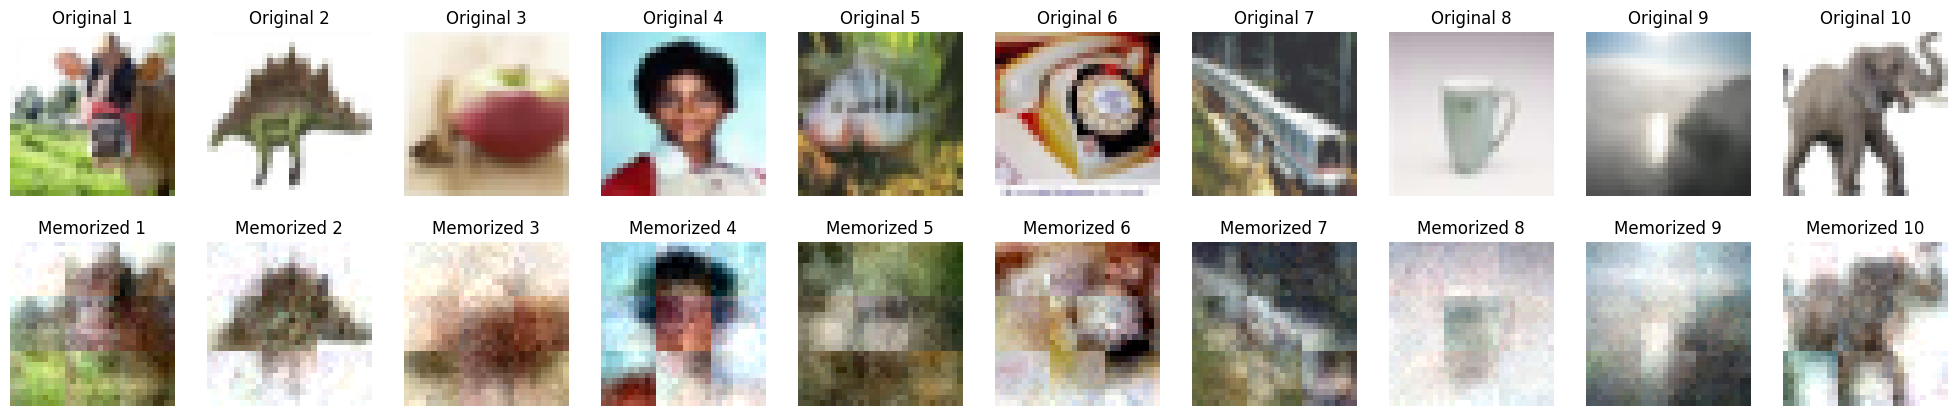

Epoch 141 | Cls Loss: 0.340775 | Mem Loss: 0.083289 | Accuracy: 0.235734 | Duration: 26.79 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0833
Epoch 142 | Cls Loss: 0.340784 | Mem Loss: 0.083066 | Accuracy: 0.223354 | Duration: 26.99 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0831
Epoch 143 | Cls Loss: 0.337543 | Mem Loss: 0.082872 | Accuracy: 0.254600 | Duration: 26.94 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0829
Epoch 144 | Cls Loss: 0.343966 | Mem Loss: 0.082902 | Accuracy: 0.224037 | Duration: 27.95 sec | Mem Loader Resets: 4
Epoch 145 | Cls Loss: 0.338910 | Mem Loss: 0.082613 | Accuracy: 0.238035 | Duration: 26.89 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0826
Epoch 146 | Cls Loss: 0.339491 | Mem Loss: 0.082270 | Accuracy: 0.235054 | Duration: 27.82 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0823
Epoch 1

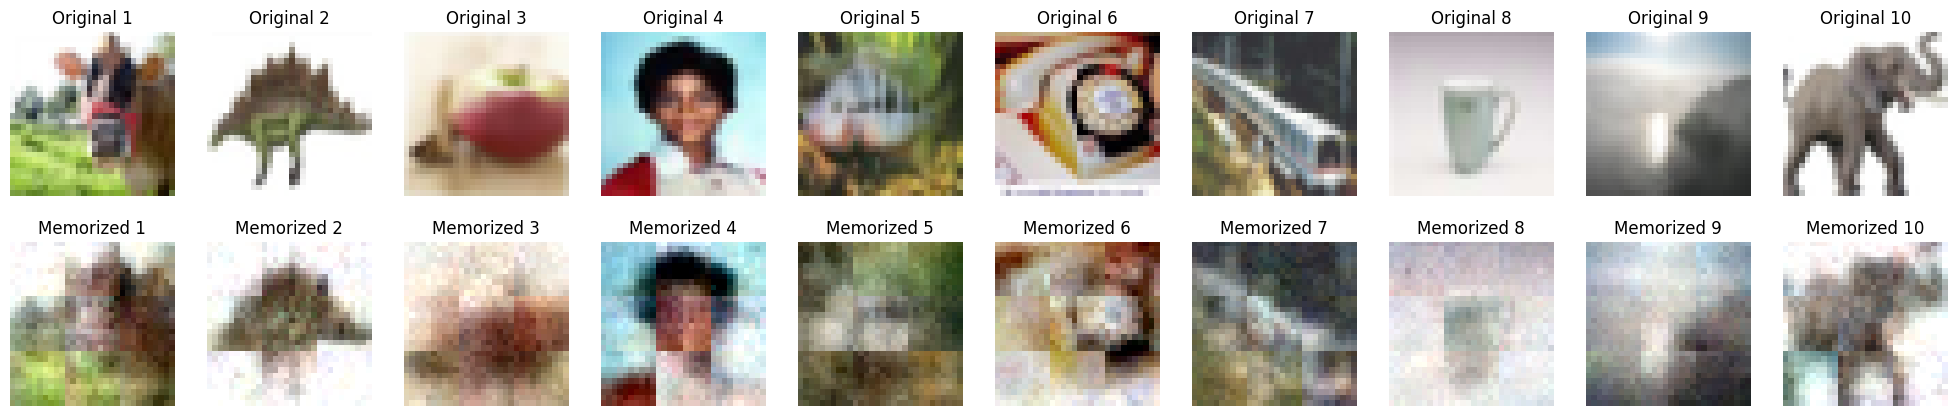

Epoch 151 | Cls Loss: 0.334090 | Mem Loss: 0.081977 | Accuracy: 0.247450 | Duration: 26.82 sec | Mem Loader Resets: 3
Epoch 152 | Cls Loss: 0.336780 | Mem Loss: 0.081602 | Accuracy: 0.232912 | Duration: 26.98 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0816
Epoch 153 | Cls Loss: 0.337603 | Mem Loss: 0.081703 | Accuracy: 0.250008 | Duration: 27.56 sec | Mem Loader Resets: 4
Epoch 154 | Cls Loss: 0.334107 | Mem Loss: 0.081645 | Accuracy: 0.262576 | Duration: 27.02 sec | Mem Loader Resets: 4
Epoch 155 | Cls Loss: 0.335621 | Mem Loss: 0.081370 | Accuracy: 0.247910 | Duration: 28.69 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0814
Epoch 156 | Cls Loss: 0.339547 | Mem Loss: 0.081239 | Accuracy: 0.239446 | Duration: 27.76 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0812
Epoch 157 | Cls Loss: 0.341224 | Mem Loss: 0.081282 | Accuracy: 0.224728 | Duration: 26.79 sec | Mem Loader Resets: 4
Epo

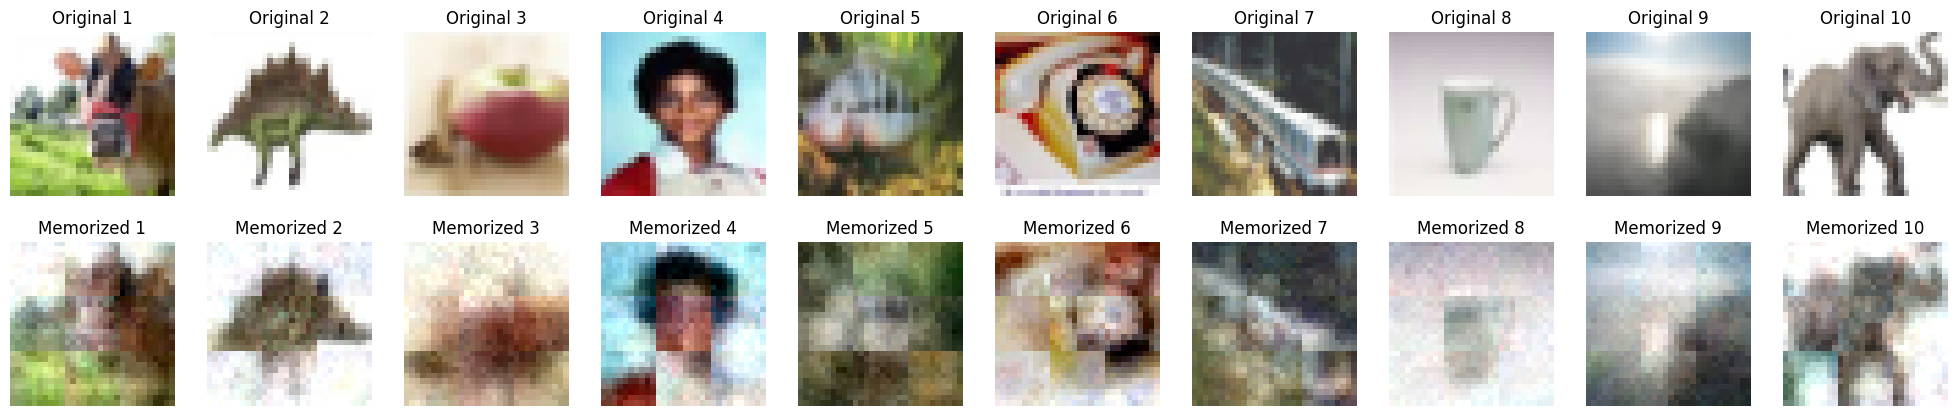

Epoch 161 | Cls Loss: 0.333289 | Mem Loss: 0.080949 | Accuracy: 0.257341 | Duration: 26.75 sec | Mem Loader Resets: 3
Epoch 162 | Cls Loss: 0.336216 | Mem Loss: 0.080868 | Accuracy: 0.246783 | Duration: 28.04 sec | Mem Loader Resets: 4
Epoch 163 | Cls Loss: 0.336494 | Mem Loss: 0.080684 | Accuracy: 0.236757 | Duration: 27.01 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0807
Epoch 164 | Cls Loss: 0.335167 | Mem Loss: 0.080676 | Accuracy: 0.237824 | Duration: 26.77 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0807
Epoch 165 | Cls Loss: 0.334182 | Mem Loss: 0.080463 | Accuracy: 0.245089 | Duration: 26.84 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0805
Epoch 166 | Cls Loss: 0.332876 | Mem Loss: 0.080446 | Accuracy: 0.256897 | Duration: 27.92 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0804
Epoch 167 | Cls Loss: 0.331308 | Mem Loss: 0.080318 | Accuracy: 

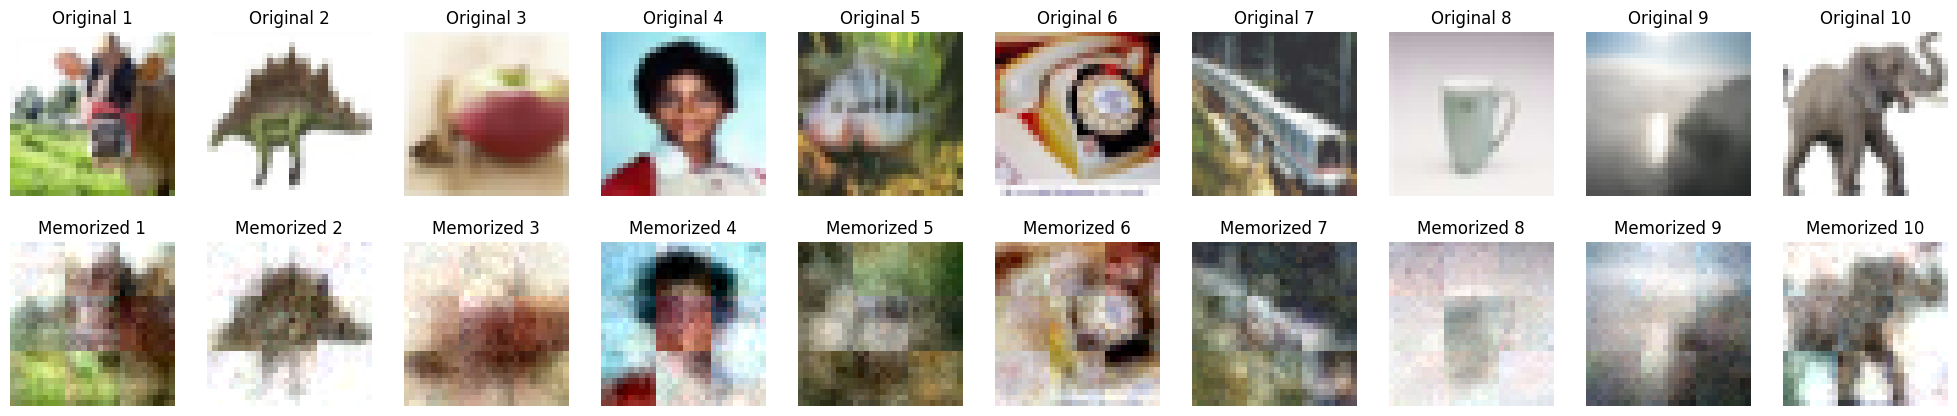

Epoch 171 | Cls Loss: 0.333682 | Mem Loss: 0.079846 | Accuracy: 0.245360 | Duration: 27.01 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0798
Epoch 172 | Cls Loss: 0.333621 | Mem Loss: 0.079581 | Accuracy: 0.245744 | Duration: 26.78 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0796
Epoch 173 | Cls Loss: 0.333525 | Mem Loss: 0.079619 | Accuracy: 0.252781 | Duration: 26.90 sec | Mem Loader Resets: 4
Epoch 174 | Cls Loss: 0.334401 | Mem Loss: 0.079653 | Accuracy: 0.248190 | Duration: 26.98 sec | Mem Loader Resets: 3
Epoch 175 | Cls Loss: 0.333388 | Mem Loss: 0.079324 | Accuracy: 0.260602 | Duration: 27.79 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0793
Epoch 176 | Cls Loss: 0.333863 | Mem Loss: 0.079390 | Accuracy: 0.241176 | Duration: 26.80 sec | Mem Loader Resets: 4
Epoch 177 | Cls Loss: 0.333043 | Mem Loss: 0.079266 | Accuracy: 0.248837 | Duration: 26.75 sec | Mem Loader Resets: 3
Sav

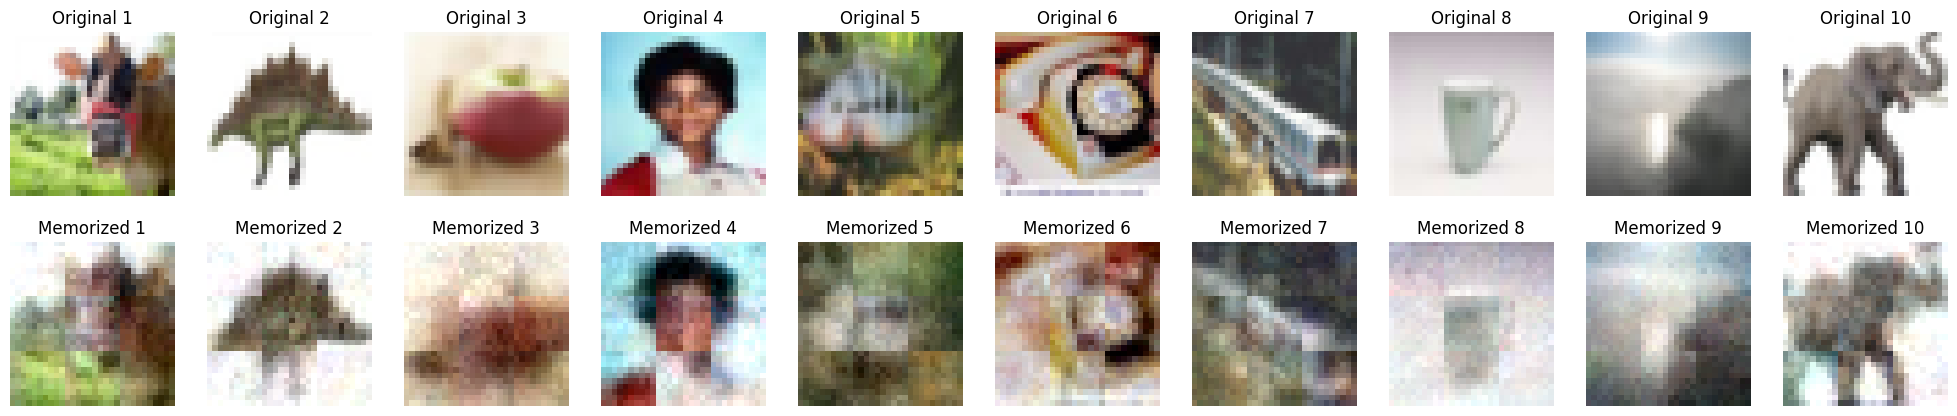

Epoch 181 | Cls Loss: 0.333801 | Mem Loss: 0.078911 | Accuracy: 0.239478 | Duration: 27.29 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0789
Epoch 182 | Cls Loss: 0.335731 | Mem Loss: 0.078671 | Accuracy: 0.234759 | Duration: 26.84 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0787
Epoch 183 | Cls Loss: 0.329287 | Mem Loss: 0.078670 | Accuracy: 0.254688 | Duration: 26.71 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0787
Epoch 184 | Cls Loss: 0.331963 | Mem Loss: 0.078581 | Accuracy: 0.256821 | Duration: 26.70 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0786
Epoch 185 | Cls Loss: 0.333502 | Mem Loss: 0.078519 | Accuracy: 0.242591 | Duration: 26.74 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0785
Epoch 186 | Cls Loss: 0.335311 | Mem Loss: 0.078434 | Accuracy: 0.250827 | Duration: 26.80 sec | Mem Loader Resets: 4
Saved m

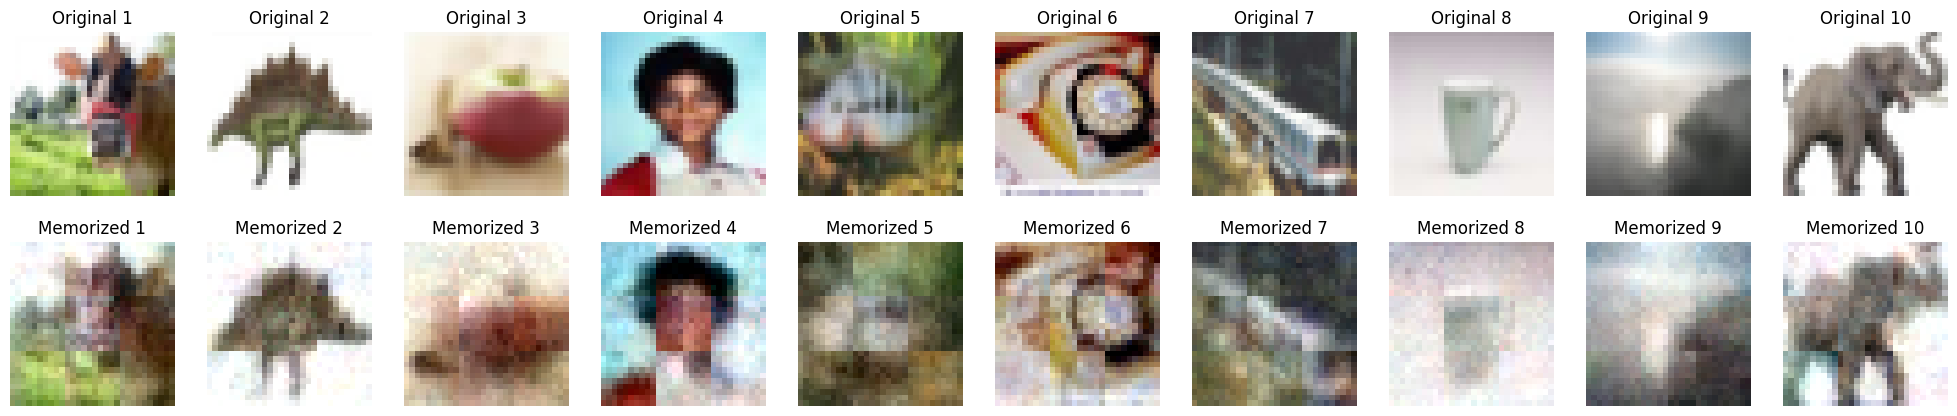

Epoch 191 | Cls Loss: 0.332063 | Mem Loss: 0.077787 | Accuracy: 0.260070 | Duration: 27.05 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0778
Epoch 192 | Cls Loss: 0.333560 | Mem Loss: 0.077839 | Accuracy: 0.254927 | Duration: 26.91 sec | Mem Loader Resets: 4
Epoch 193 | Cls Loss: 0.333136 | Mem Loss: 0.077740 | Accuracy: 0.254624 | Duration: 27.58 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0777
Epoch 194 | Cls Loss: 0.332196 | Mem Loss: 0.077485 | Accuracy: 0.256298 | Duration: 26.78 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0775
Epoch 195 | Cls Loss: 0.329093 | Mem Loss: 0.077614 | Accuracy: 0.257237 | Duration: 26.83 sec | Mem Loader Resets: 4
Epoch 196 | Cls Loss: 0.332726 | Mem Loss: 0.077519 | Accuracy: 0.265405 | Duration: 26.77 sec | Mem Loader Resets: 3
Epoch 197 | Cls Loss: 0.330083 | Mem Loss: 0.077312 | Accuracy: 0.267783 | Duration: 27.83 sec | Mem Loader Resets: 4
Sav

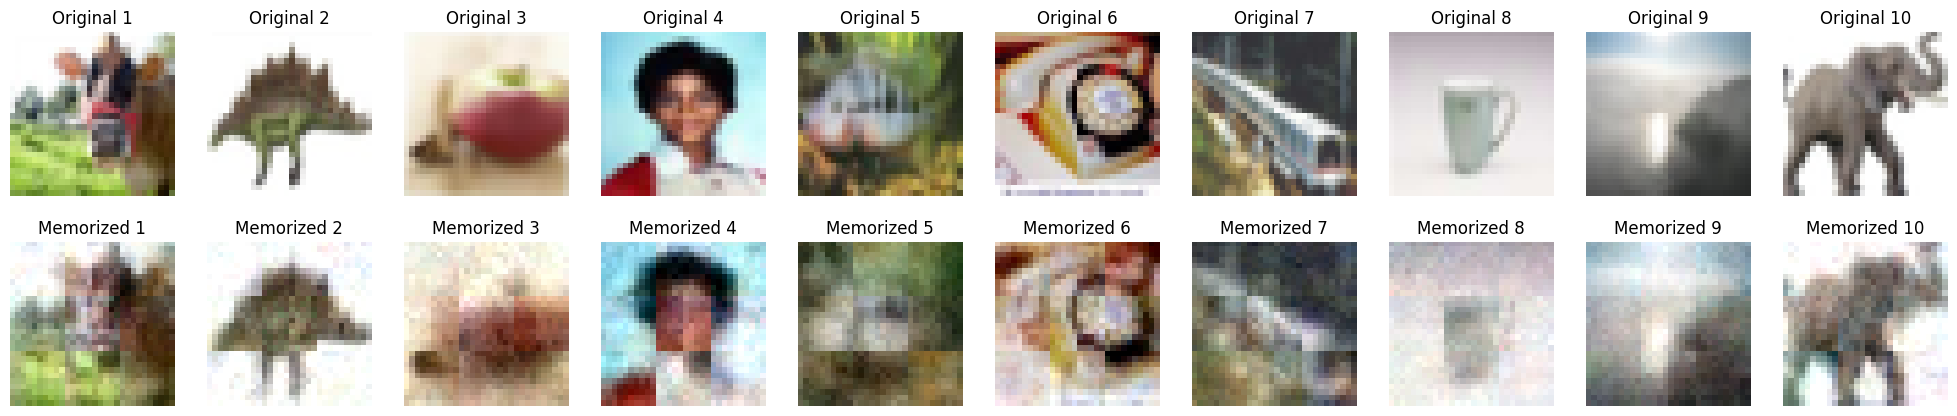

Epoch 201 | Cls Loss: 0.329110 | Mem Loss: 0.076965 | Accuracy: 0.269909 | Duration: 26.82 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0770
Epoch 202 | Cls Loss: 0.329740 | Mem Loss: 0.077029 | Accuracy: 0.252530 | Duration: 26.74 sec | Mem Loader Resets: 4
Epoch 203 | Cls Loss: 0.331632 | Mem Loss: 0.076879 | Accuracy: 0.255818 | Duration: 27.05 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0769
Epoch 204 | Cls Loss: 0.331267 | Mem Loss: 0.076690 | Accuracy: 0.284387 | Duration: 26.83 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0767
Epoch 205 | Cls Loss: 0.333588 | Mem Loss: 0.076822 | Accuracy: 0.260414 | Duration: 26.88 sec | Mem Loader Resets: 4
Epoch 206 | Cls Loss: 0.327876 | Mem Loss: 0.076746 | Accuracy: 0.266980 | Duration: 26.96 sec | Mem Loader Resets: 3
Epoch 207 | Cls Loss: 0.332217 | Mem Loss: 0.076588 | Accuracy: 0.252857 | Duration: 27.81 sec | Mem Loader Resets: 4
Sav

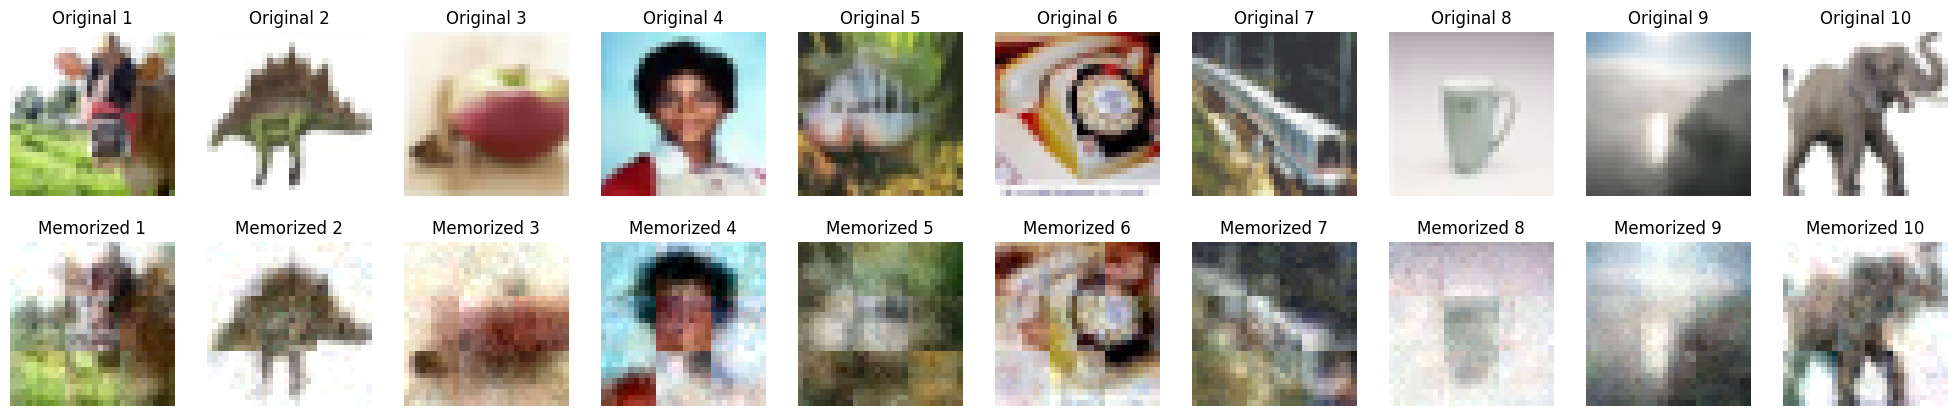

Epoch 211 | Cls Loss: 0.329333 | Mem Loss: 0.076366 | Accuracy: 0.260562 | Duration: 26.96 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0764
Epoch 212 | Cls Loss: 0.331034 | Mem Loss: 0.076251 | Accuracy: 0.257537 | Duration: 27.72 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0763
Epoch 213 | Cls Loss: 0.327258 | Mem Loss: 0.075992 | Accuracy: 0.268762 | Duration: 26.59 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0760
Epoch 214 | Cls Loss: 0.330588 | Mem Loss: 0.076016 | Accuracy: 0.262752 | Duration: 26.89 sec | Mem Loader Resets: 4
Epoch 215 | Cls Loss: 0.332730 | Mem Loss: 0.075994 | Accuracy: 0.244062 | Duration: 26.94 sec | Mem Loader Resets: 4
Epoch 216 | Cls Loss: 0.331011 | Mem Loss: 0.075742 | Accuracy: 0.270684 | Duration: 26.96 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0757
Epoch 217 | Cls Loss: 0.329023 | Mem Loss: 0.075788 | Accuracy: 

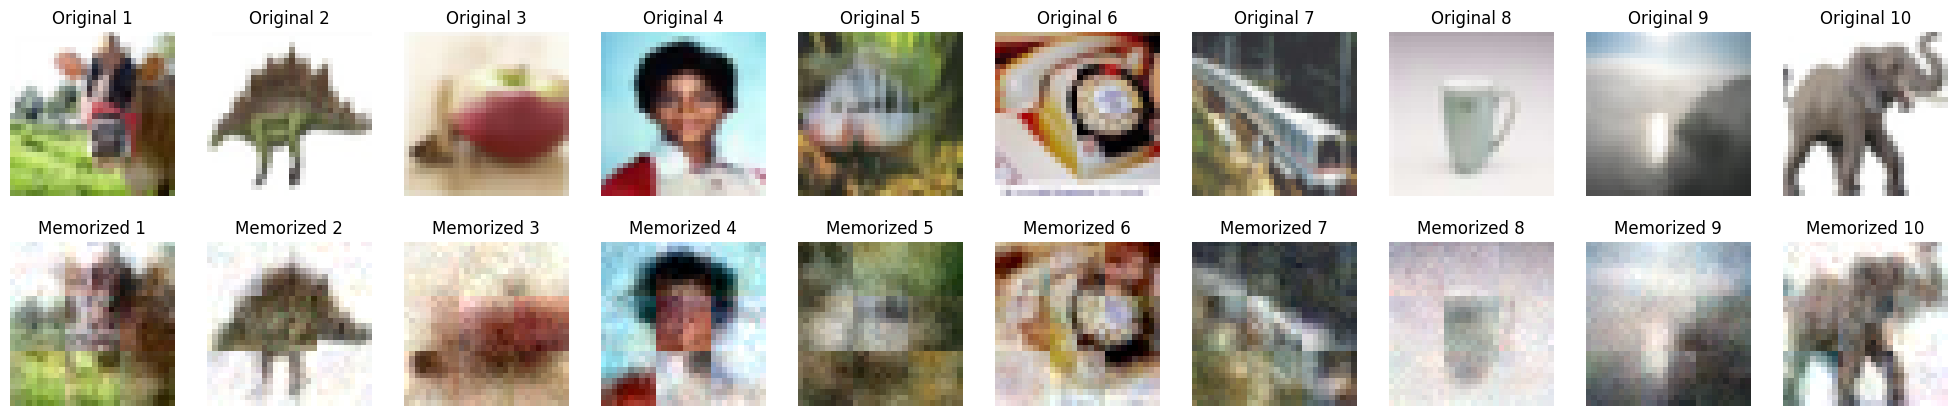

Epoch 221 | Cls Loss: 0.328951 | Mem Loss: 0.075605 | Accuracy: 0.256969 | Duration: 27.79 sec | Mem Loader Resets: 4
Epoch 222 | Cls Loss: 0.326746 | Mem Loss: 0.075314 | Accuracy: 0.257229 | Duration: 26.77 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0753
Epoch 223 | Cls Loss: 0.324287 | Mem Loss: 0.075304 | Accuracy: 0.272734 | Duration: 27.70 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0753
Epoch 224 | Cls Loss: 0.325829 | Mem Loss: 0.075159 | Accuracy: 0.264410 | Duration: 26.84 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0752
Epoch 225 | Cls Loss: 0.329430 | Mem Loss: 0.075154 | Accuracy: 0.250228 | Duration: 26.78 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0752
Epoch 226 | Cls Loss: 0.330584 | Mem Loss: 0.074988 | Accuracy: 0.250320 | Duration: 27.40 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0750
Epoch 2

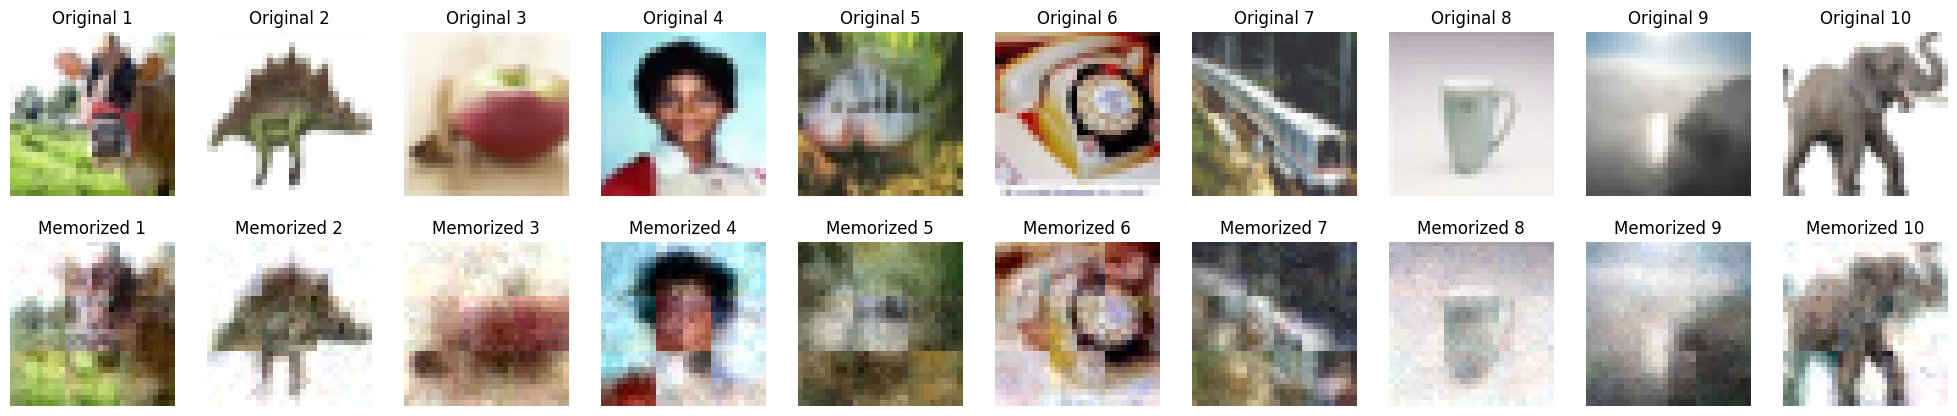

Epoch 231 | Cls Loss: 0.324386 | Mem Loss: 0.074705 | Accuracy: 0.271040 | Duration: 27.01 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0747
Epoch 232 | Cls Loss: 0.326179 | Mem Loss: 0.074647 | Accuracy: 0.259259 | Duration: 26.91 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0746
Epoch 233 | Cls Loss: 0.329924 | Mem Loss: 0.074465 | Accuracy: 0.260945 | Duration: 27.65 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0745
Epoch 234 | Cls Loss: 0.323949 | Mem Loss: 0.074447 | Accuracy: 0.275476 | Duration: 26.97 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0744
Epoch 235 | Cls Loss: 0.325262 | Mem Loss: 0.074488 | Accuracy: 0.273913 | Duration: 28.03 sec | Mem Loader Resets: 3
Epoch 236 | Cls Loss: 0.326100 | Mem Loss: 0.074287 | Accuracy: 0.249648 | Duration: 28.02 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0743
Epoch 2

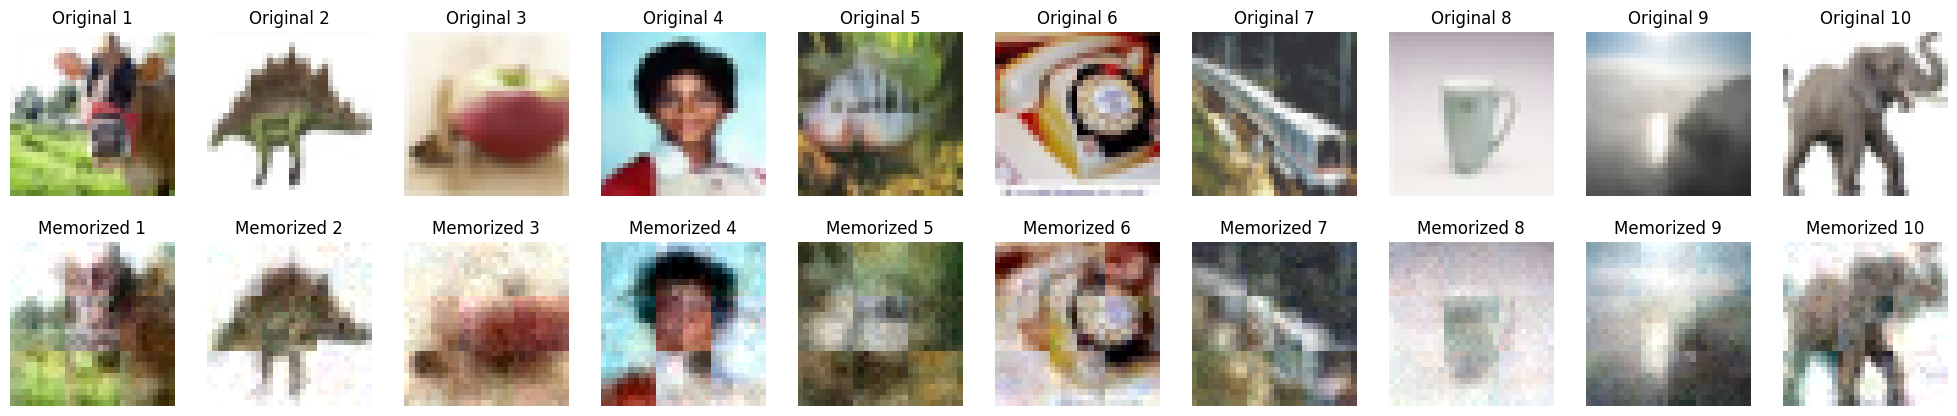

Epoch 241 | Cls Loss: 0.326963 | Mem Loss: 0.074056 | Accuracy: 0.270612 | Duration: 26.78 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0741
Epoch 242 | Cls Loss: 0.328137 | Mem Loss: 0.074114 | Accuracy: 0.277613 | Duration: 26.93 sec | Mem Loader Resets: 4
Epoch 243 | Cls Loss: 0.324461 | Mem Loss: 0.073876 | Accuracy: 0.260422 | Duration: 26.67 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0739
Epoch 244 | Cls Loss: 0.327799 | Mem Loss: 0.073933 | Accuracy: 0.278509 | Duration: 27.71 sec | Mem Loader Resets: 4
Epoch 245 | Cls Loss: 0.328296 | Mem Loss: 0.073798 | Accuracy: 0.275863 | Duration: 26.67 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0738
Epoch 246 | Cls Loss: 0.324302 | Mem Loss: 0.073730 | Accuracy: 0.289382 | Duration: 26.80 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0737
Epoch 247 | Cls Loss: 0.325477 | Mem Loss: 0.073831 | Accuracy: 

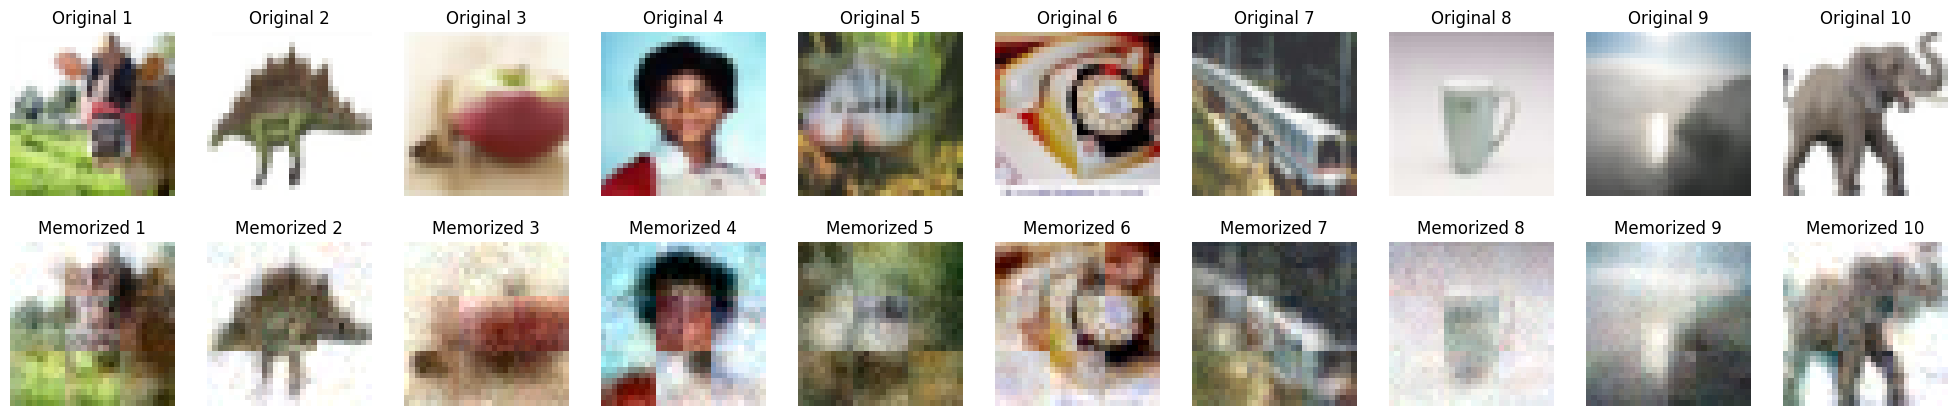

Epoch 251 | Cls Loss: 0.325911 | Mem Loss: 0.073630 | Accuracy: 0.279136 | Duration: 26.84 sec | Mem Loader Resets: 3
Epoch 252 | Cls Loss: 0.325297 | Mem Loss: 0.073385 | Accuracy: 0.267575 | Duration: 26.74 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0734
Epoch 253 | Cls Loss: 0.325667 | Mem Loss: 0.073505 | Accuracy: 0.263447 | Duration: 26.88 sec | Mem Loader Resets: 4
Epoch 254 | Cls Loss: 0.326793 | Mem Loss: 0.073466 | Accuracy: 0.267227 | Duration: 26.72 sec | Mem Loader Resets: 3
Epoch 255 | Cls Loss: 0.326366 | Mem Loss: 0.073403 | Accuracy: 0.252901 | Duration: 27.76 sec | Mem Loader Resets: 4
Epoch 256 | Cls Loss: 0.326949 | Mem Loss: 0.073404 | Accuracy: 0.275392 | Duration: 26.94 sec | Mem Loader Resets: 4
Epoch 257 | Cls Loss: 0.324639 | Mem Loss: 0.073307 | Accuracy: 0.281490 | Duration: 27.59 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0733
Epoch 258 | Cls Loss: 0.321902 | Mem Loss: 0.073168 | Accura

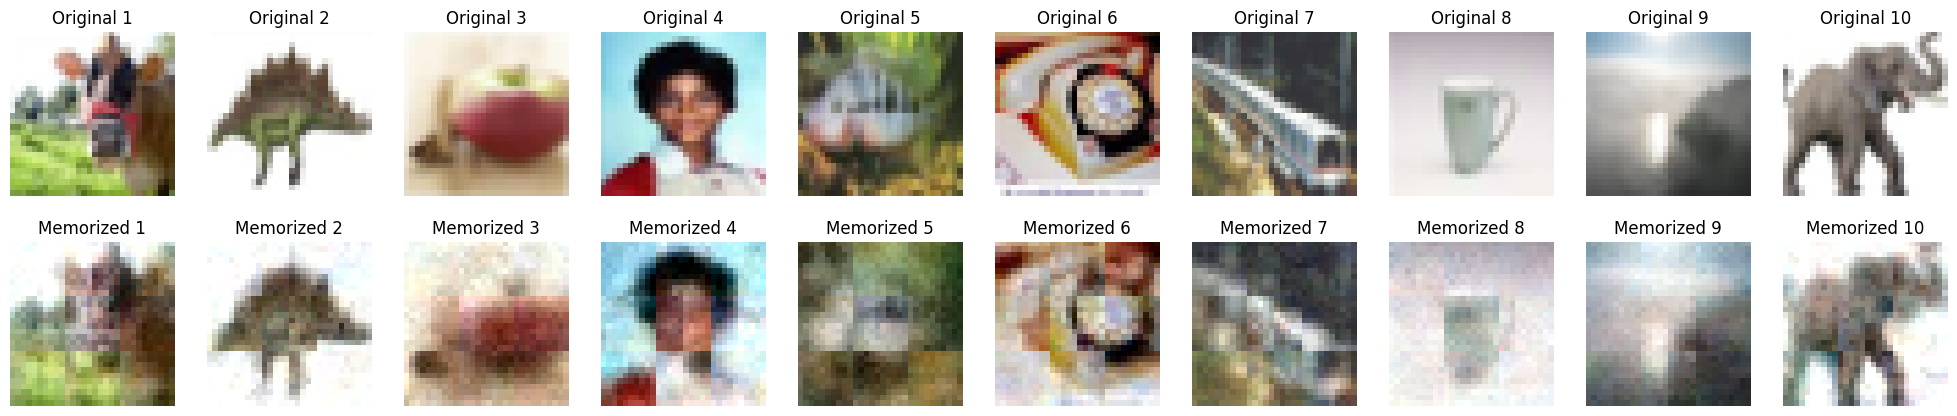

Epoch 261 | Cls Loss: 0.323417 | Mem Loss: 0.073153 | Accuracy: 0.287780 | Duration: 27.94 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0732
Epoch 262 | Cls Loss: 0.323248 | Mem Loss: 0.073017 | Accuracy: 0.274401 | Duration: 26.78 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0730
Epoch 263 | Cls Loss: 0.321765 | Mem Loss: 0.073070 | Accuracy: 0.274029 | Duration: 27.11 sec | Mem Loader Resets: 4
Epoch 264 | Cls Loss: 0.326927 | Mem Loss: 0.072889 | Accuracy: 0.273961 | Duration: 26.80 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0729
Epoch 265 | Cls Loss: 0.327208 | Mem Loss: 0.073009 | Accuracy: 0.271687 | Duration: 26.91 sec | Mem Loader Resets: 4
Epoch 266 | Cls Loss: 0.321674 | Mem Loss: 0.072685 | Accuracy: 0.271172 | Duration: 28.09 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0727
Epoch 267 | Cls Loss: 0.317470 | Mem Loss: 0.072831 | Accuracy: 

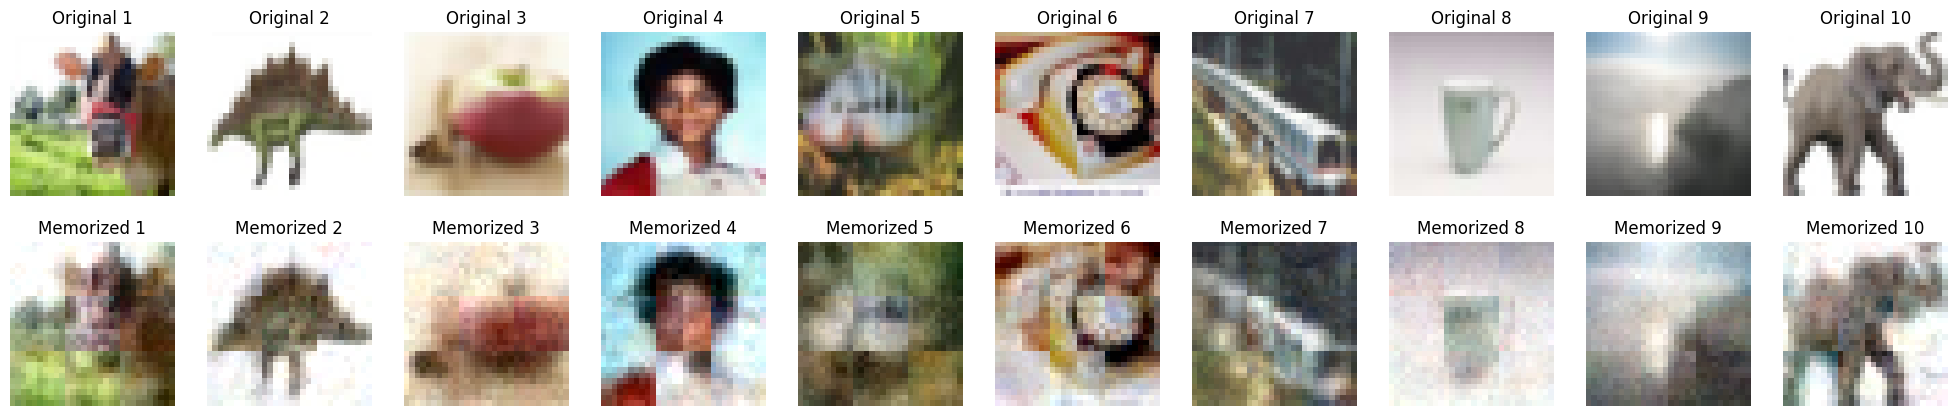

Epoch 271 | Cls Loss: 0.323229 | Mem Loss: 0.072674 | Accuracy: 0.258824 | Duration: 26.65 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0727
Epoch 272 | Cls Loss: 0.324791 | Mem Loss: 0.072436 | Accuracy: 0.273094 | Duration: 27.14 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0724
Epoch 273 | Cls Loss: 0.325074 | Mem Loss: 0.072562 | Accuracy: 0.266828 | Duration: 26.99 sec | Mem Loader Resets: 4
Epoch 274 | Cls Loss: 0.322117 | Mem Loss: 0.072497 | Accuracy: 0.275488 | Duration: 27.44 sec | Mem Loader Resets: 3
Epoch 275 | Cls Loss: 0.320744 | Mem Loss: 0.072479 | Accuracy: 0.268674 | Duration: 27.38 sec | Mem Loader Resets: 4
Epoch 276 | Cls Loss: 0.323676 | Mem Loss: 0.072456 | Accuracy: 0.268103 | Duration: 27.51 sec | Mem Loader Resets: 4
Epoch 277 | Cls Loss: 0.322099 | Mem Loss: 0.072301 | Accuracy: 0.277845 | Duration: 27.67 sec | Mem Loader Resets: 3
Saved model and optimizer with memorization loss: 0.0723
Epo

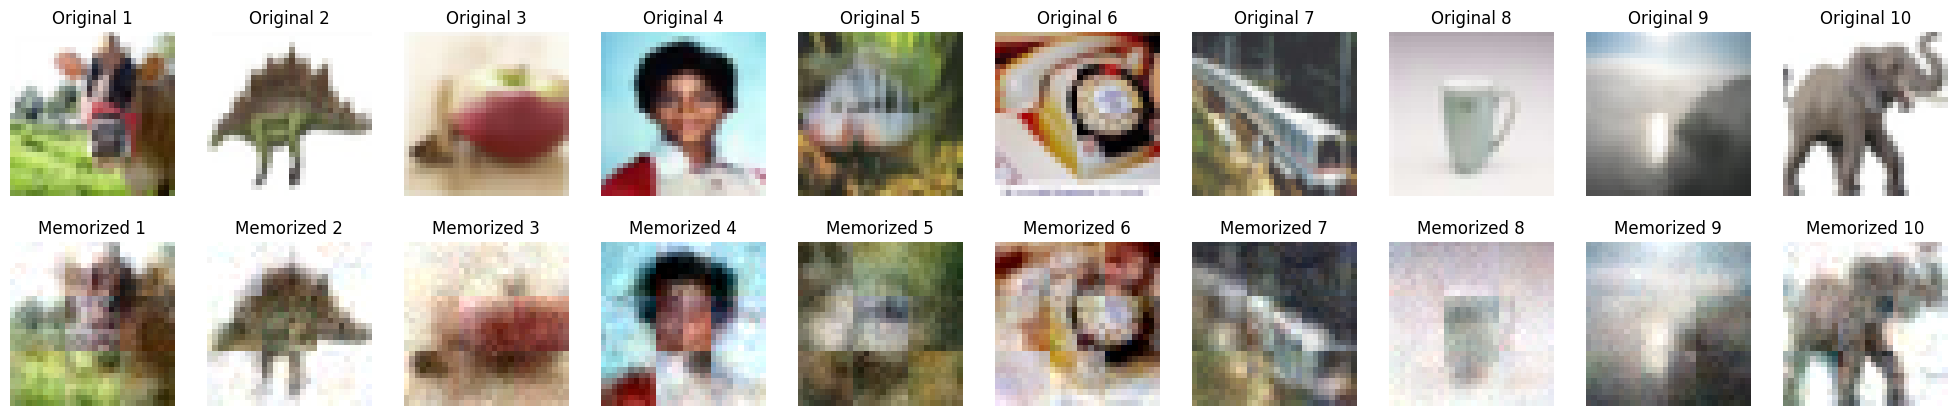

Epoch 281 | Cls Loss: 0.322296 | Mem Loss: 0.072222 | Accuracy: 0.279044 | Duration: 26.63 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0722
Epoch 282 | Cls Loss: 0.324955 | Mem Loss: 0.072111 | Accuracy: 0.261401 | Duration: 26.76 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0721
Epoch 283 | Cls Loss: 0.324129 | Mem Loss: 0.072263 | Accuracy: 0.270400 | Duration: 26.69 sec | Mem Loader Resets: 3
Epoch 284 | Cls Loss: 0.322022 | Mem Loss: 0.071993 | Accuracy: 0.274884 | Duration: 26.80 sec | Mem Loader Resets: 4
Saved model and optimizer with memorization loss: 0.0720
Epoch 285 | Cls Loss: 0.323231 | Mem Loss: 0.072171 | Accuracy: 0.282529 | Duration: 27.03 sec | Mem Loader Resets: 4
Epoch 286 | Cls Loss: 0.321973 | Mem Loss: 0.072122 | Accuracy: 0.275288 | Duration: 27.37 sec | Mem Loader Resets: 3


In [ ]:
train(model, train_loader_cls, mem_dataloader, EPOCHS, device)

## Evaluation

In [ ]:
def load_model(model_path, model, optimizer, device):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)
    return model, optimizer

In [ ]:
best_model, _ = load_model(MODEL_PATH, model, optimizer, device)

Test Accuracy

In [ ]:
def test_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    model.eval()
    model.to(device)
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
test_accuracy(best_model, test_loader_cls , device)

0.6119

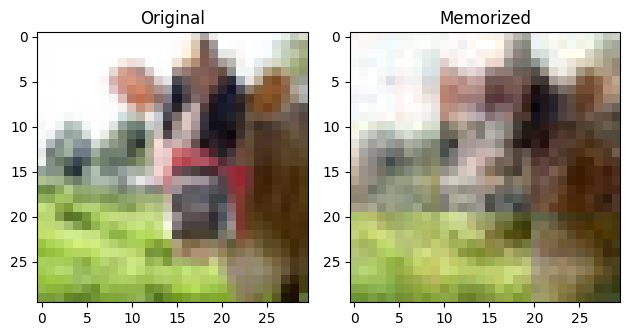

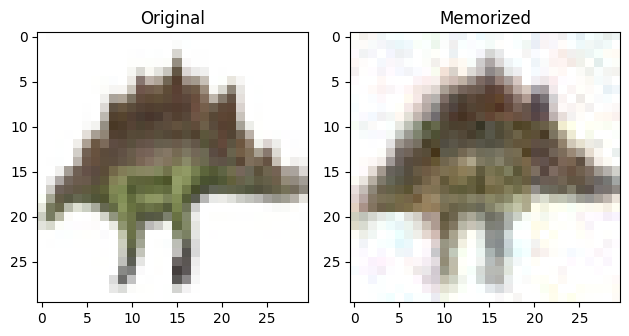

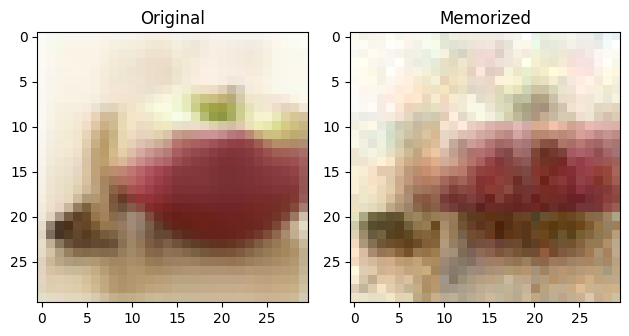

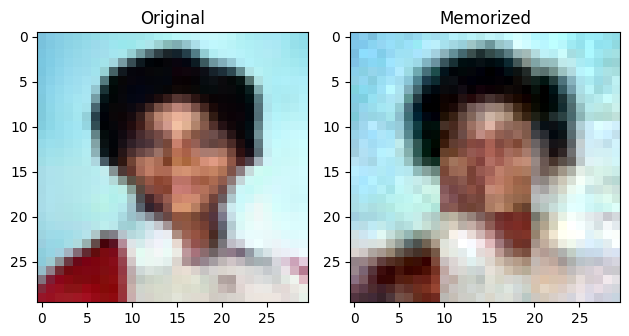

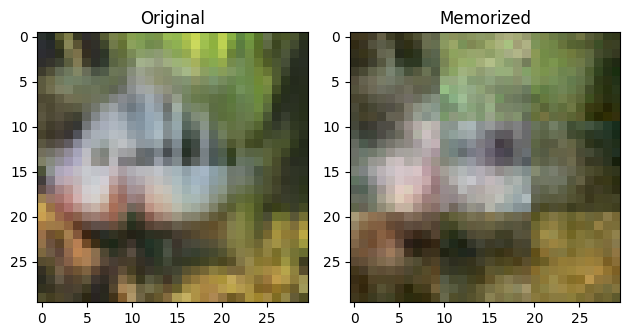

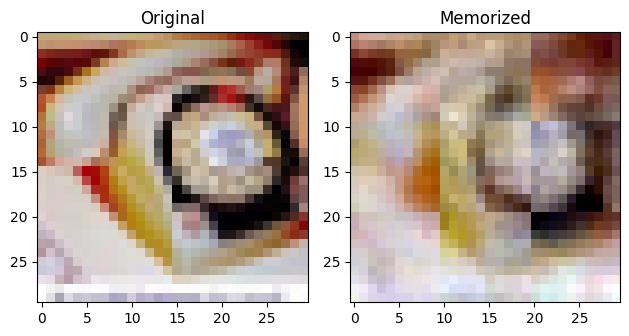

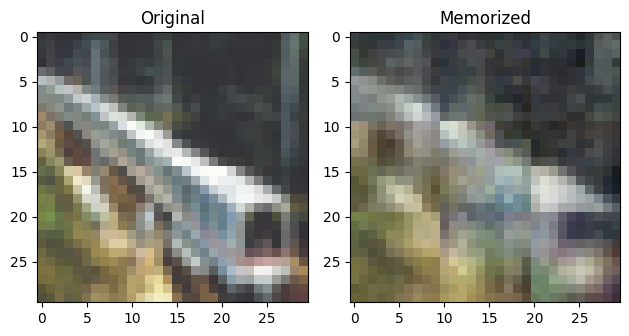

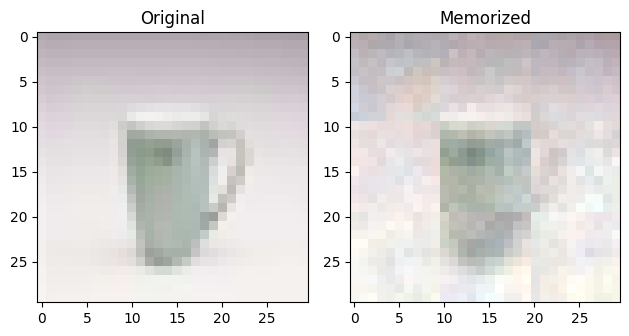

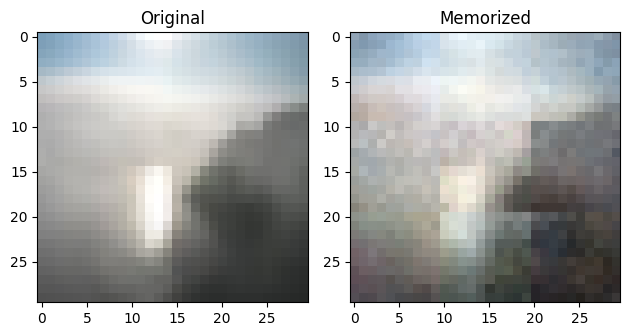

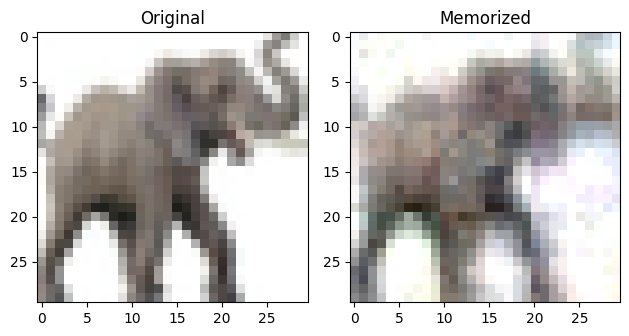

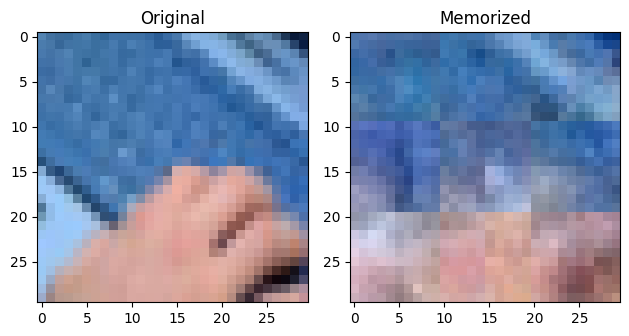

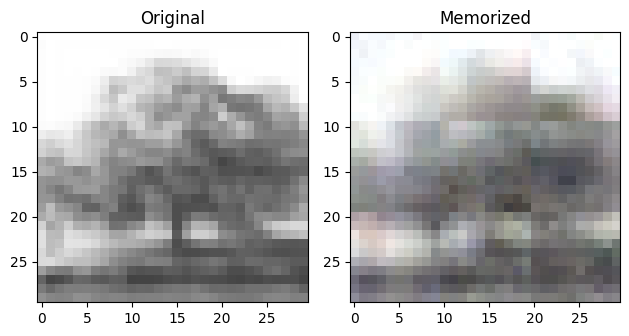

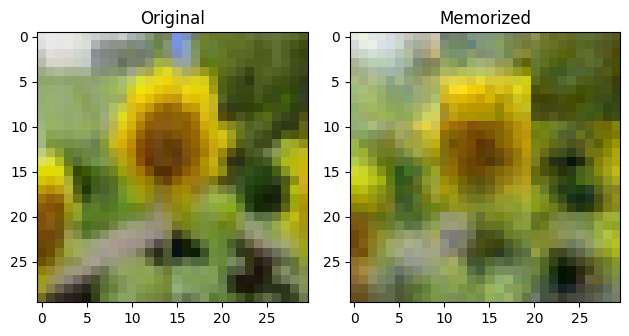

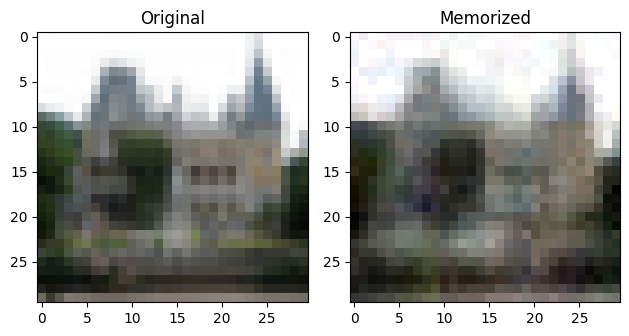

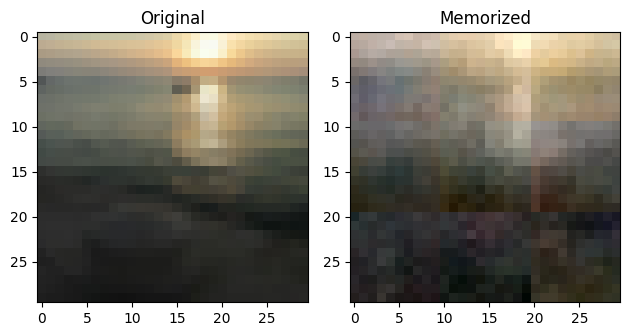

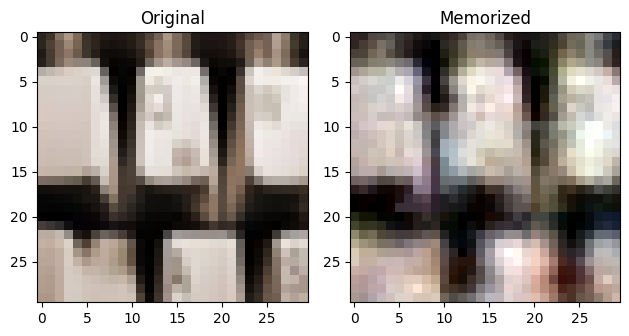

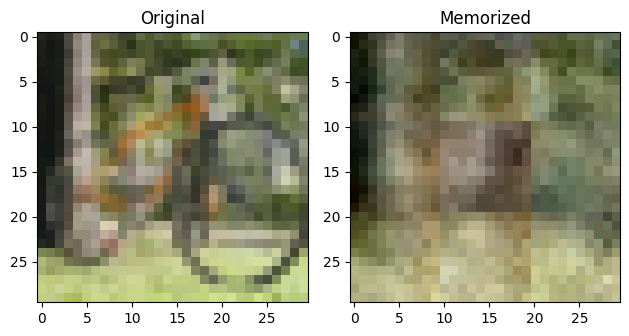

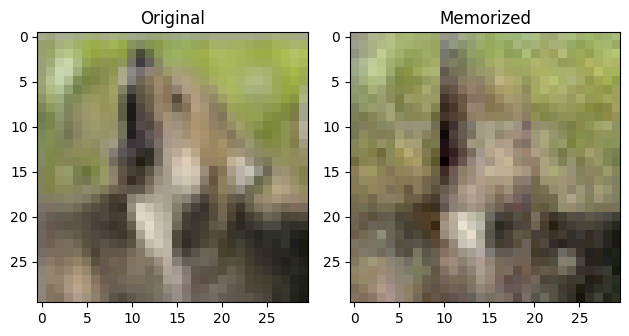

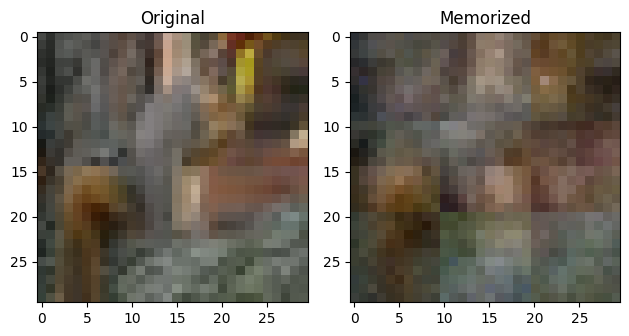

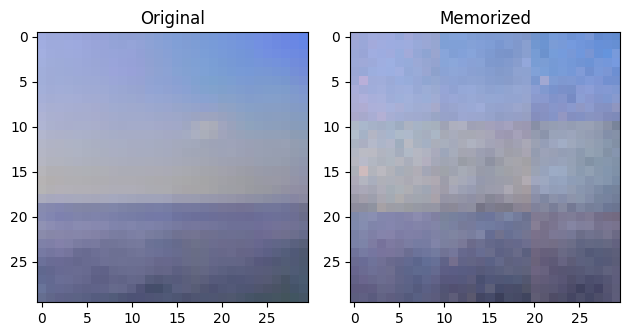

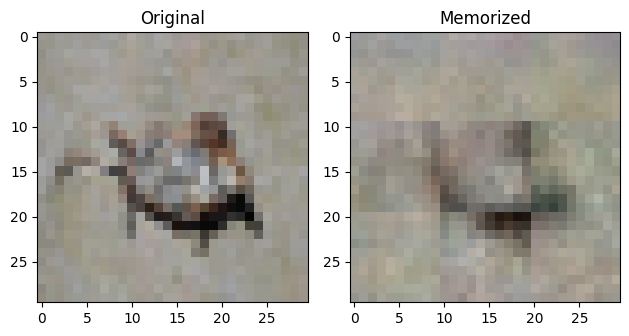

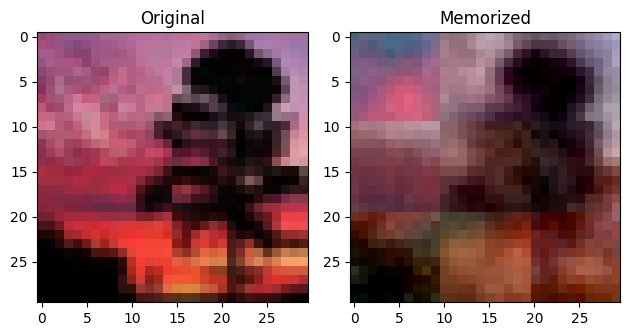

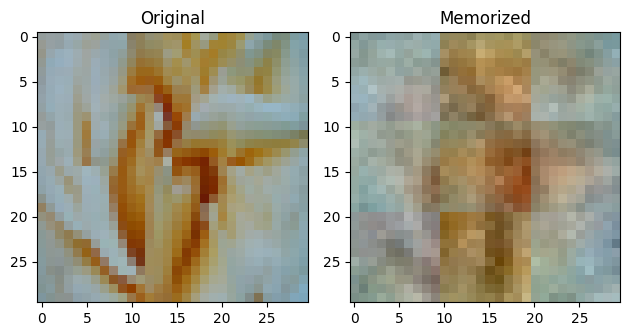

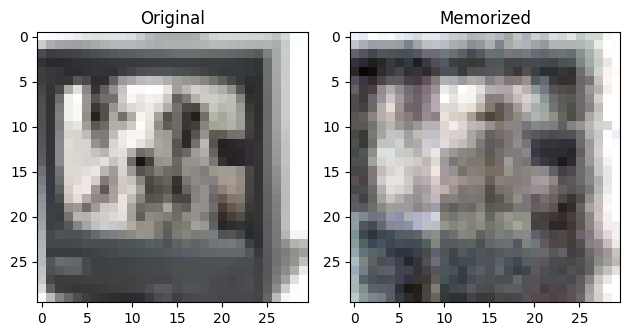

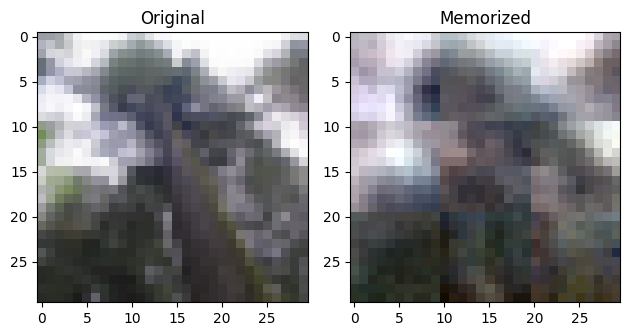

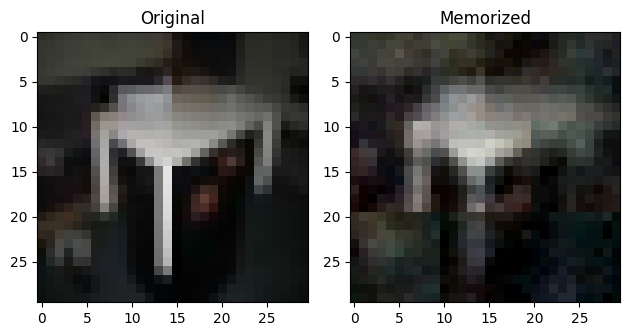

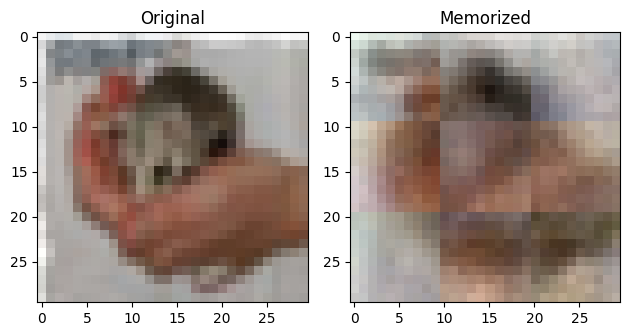

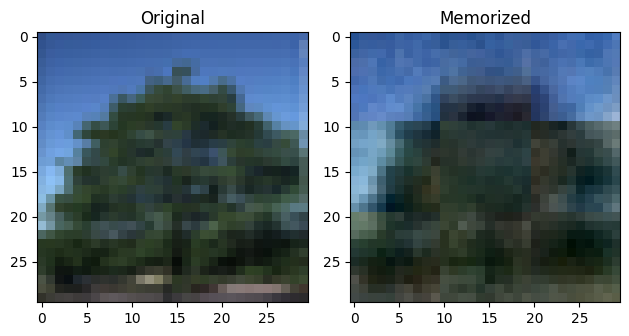

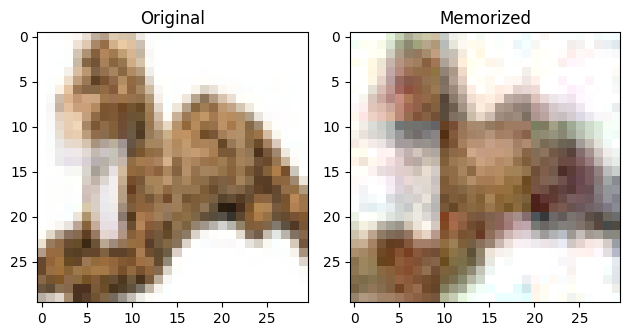

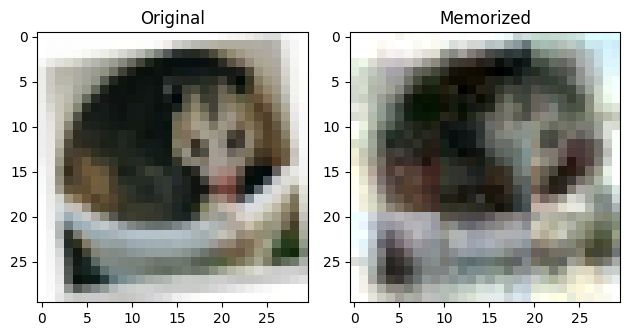

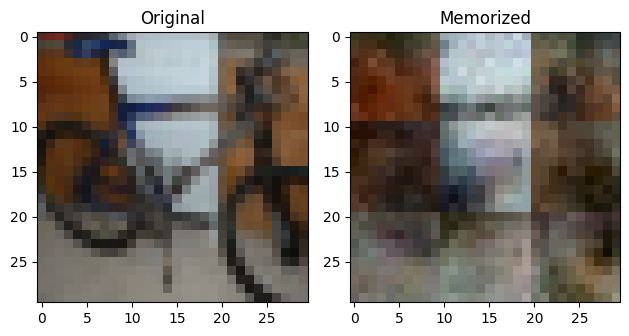

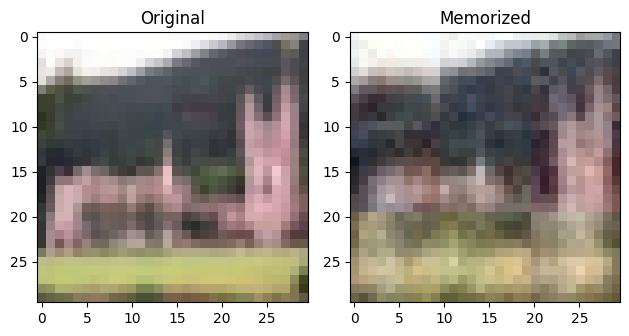

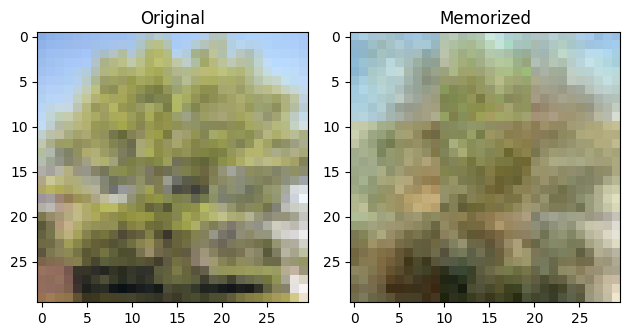

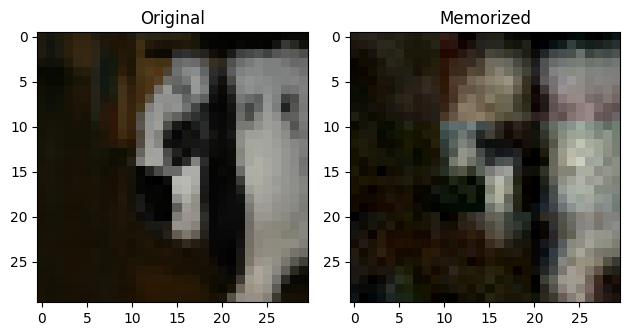

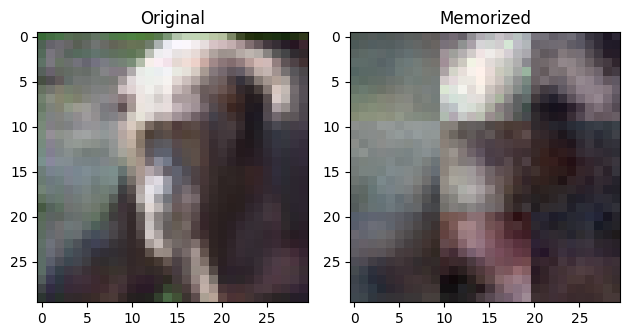

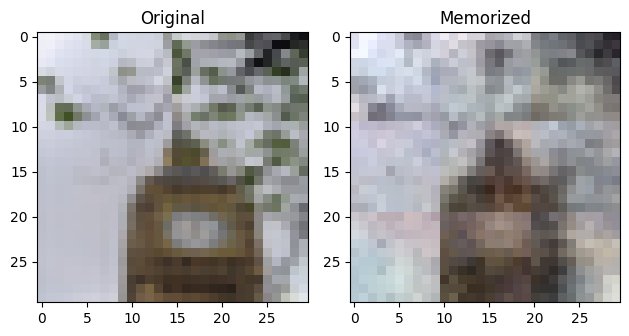

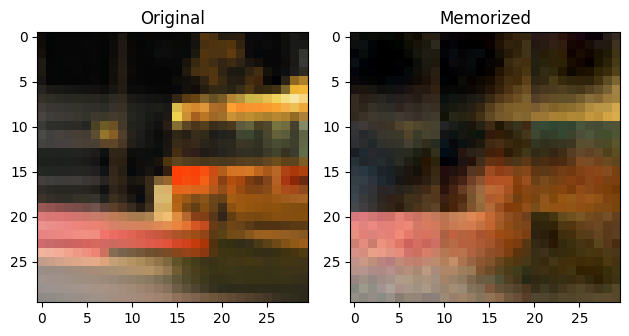

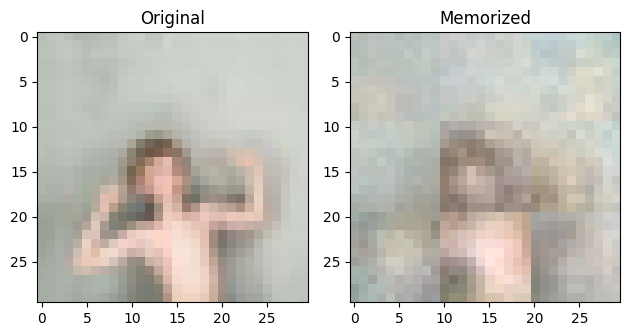

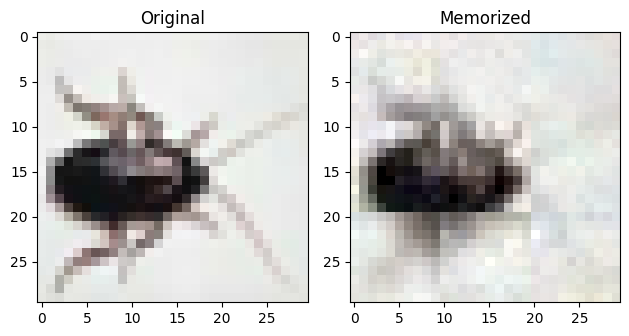

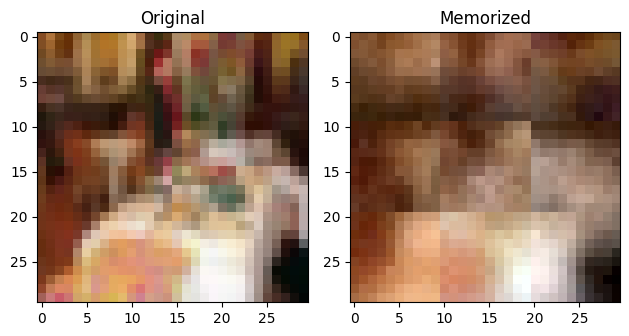

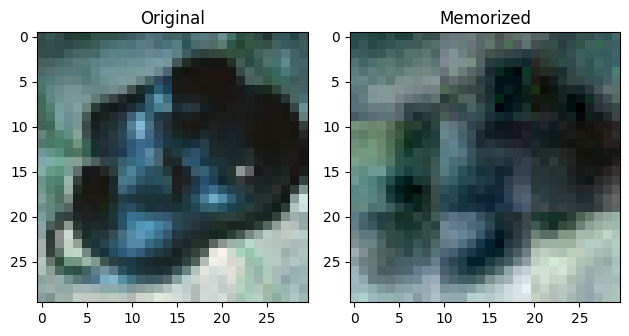

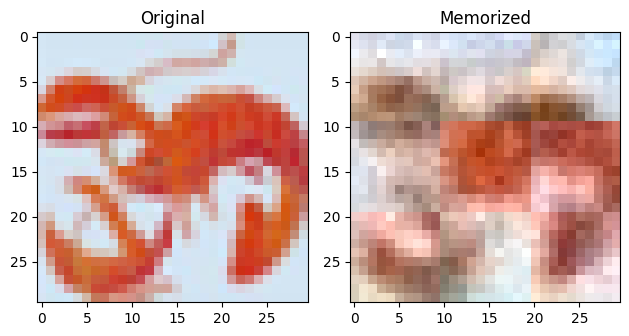

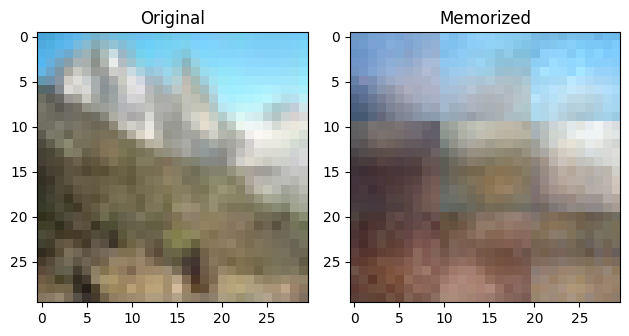

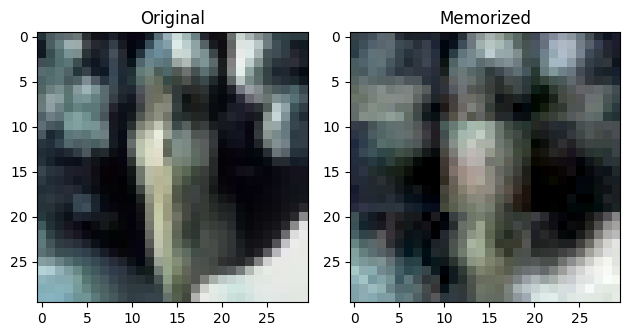

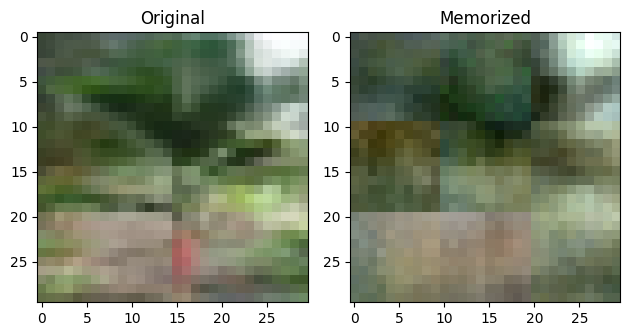

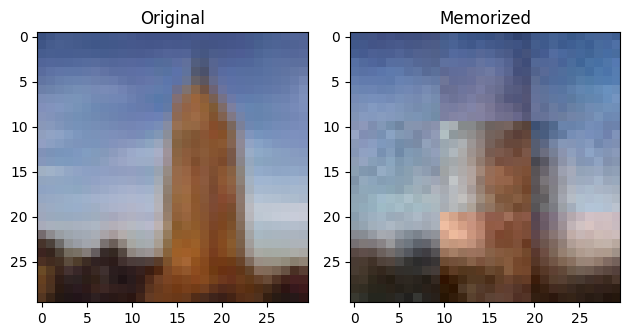

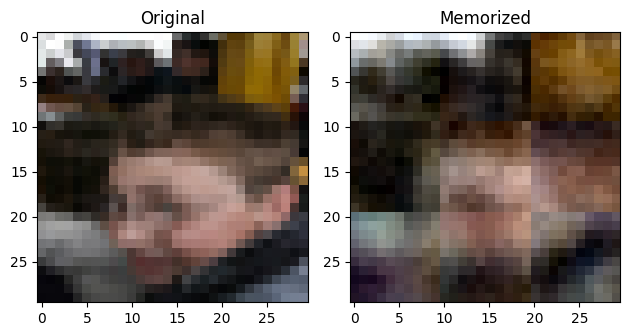

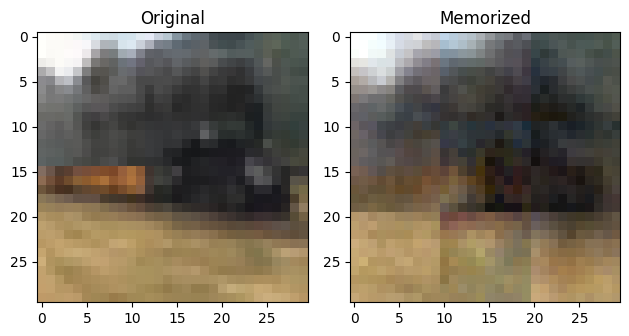

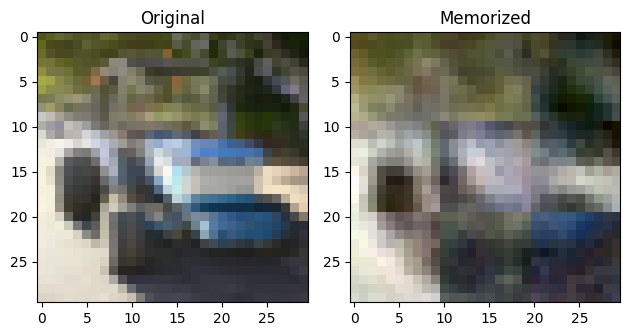

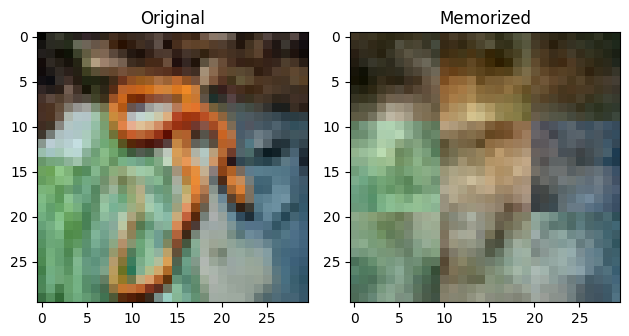

In [ ]:
# model = best_model
for idx in range(50):
    output, target_image = get_image(idx, model)
    target_image = target_image / 255.0
    target_image_perm = target_image.permute(1, 2, 0).cpu().numpy()
    output_perm = torch.clamp(output, 0, 1).permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(ncols=2, tight_layout=True)
    ax[0].imshow(target_image_perm)
    ax[0].set_title('Original')
    ax[1].imshow(output_perm)
    ax[1].set_title('Memorized')
    plt.show()

In [ ]:
def generate_reconstructed_images_and_labels(model, device, mem_dataset):
    num_samples = int(SAMPLE_PERCENTAGE * TRAIN_DATASET_LEN)

    reconstructed_images = []
    original_images = []
    labels = []

    for idx in range(num_samples):
        output, target_image = get_image(idx, model)
        reconstructed_images.append(output.to(device))
        original_images.append(target_image.to(device))

        one_hot_label_region = mem_dataset.gray_codes[idx][1][:-3, :]
        label = one_hot_label_region.argmax().item()
        labels.append(label)

    reconstructed_images = torch.stack(reconstructed_images)
    original_images = torch.stack(original_images)

    # Normalize the original images to [0, 1]
    original_images = original_images.float() / 255.0
    # Clamp the reconstructed images to [0, 1] to remove any negative values
    reconstructed_images = torch.clamp(reconstructed_images, 0, 1)
    labels = torch.tensor(labels, device=device)

    return reconstructed_images, original_images, labels

SSIM

In [ ]:
# ssim token from GitHub - https://github.com/Po-Hsun-Su/pytorch-ssim/blob/master/pytorch_ssim/__init__.py
import torch
import torch.nn.functional as F

WINDOW_SIZE = 3

def gaussian(window_size, sigma):
    gauss = torch.tensor([-(x - window_size // 2) ** 2 / float(2 * sigma ** 2) for x in range(window_size)])
    gauss = torch.exp(gauss)
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def ssim(img1, img2, window_size=WINDOW_SIZE, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    window = window.to(img1.device)
    return _ssim(img1, img2, window, window_size, channel, size_average)

# add this function

def calculate_ssim_for_batches(reconstructed_images, original_images, window_size=WINDOW_SIZE):
    if reconstructed_images.dim() == 3:  # Add channel dimension if not present
        reconstructed_images = reconstructed_images.unsqueeze(1)
    if original_images.dim() == 3:  # Add channel dimension if not present
        original_images = original_images.unsqueeze(1)

    device = original_images.device
    channel = original_images.size(1)
    window = create_window(window_size, channel).to(device)
    window = window.to(device)

    # Calculate SSIM for each image in the batch
    ssim_scores = _ssim(reconstructed_images, original_images, window, window_size, channel, size_average=False)
    return ssim_scores, ssim_scores.mean().item()


In [ ]:
# Generate reconstructed images and original images
reconstructed_images, original_images, labels = generate_reconstructed_images_and_labels(best_model, device, mem_dataset)

# Calculate SSIM values for the batches
ssim_values, average_ssim = calculate_ssim_for_batches(reconstructed_images, original_images)

# Print SSIM values and the average SSIM
print(f'SSIM values: {ssim_values}')
print(ssim_values.shape)
print(f'Average SSIM: {average_ssim}')

SSIM values: tensor([0.7223, 0.7574, 0.7384, 0.6952, 0.6858, 0.6193, 0.6379, 0.7825, 0.8053,
        0.7174, 0.5248, 0.7575, 0.6321, 0.7441, 0.7326, 0.7082, 0.5504, 0.6426,
        0.5760, 0.7746, 0.6354, 0.5187, 0.5244, 0.7288, 0.6710, 0.6719, 0.6153,
        0.6809, 0.7011, 0.7434, 0.6279, 0.7105, 0.6488, 0.6384, 0.6468, 0.6251,
        0.5690, 0.7317, 0.7108, 0.5360, 0.5906, 0.5300, 0.5574, 0.6488, 0.6168,
        0.6817, 0.6228, 0.6117, 0.6216, 0.4843, 0.6124, 0.5718, 0.6352, 0.7175,
        0.6694, 0.7061, 0.6432, 0.5833, 0.6498, 0.5719, 0.6319, 0.6901, 0.7057,
        0.6482, 0.5990, 0.6486, 0.5832, 0.5660, 0.6719, 0.4779, 0.5843, 0.5951,
        0.7508, 0.6403, 0.5531, 0.7272, 0.5526, 0.5077, 0.5807, 0.6109, 0.5645,
        0.5275, 0.5717, 0.5138, 0.7356, 0.6124, 0.5734, 0.5980, 0.6125, 0.5376,
        0.5626, 0.7723, 0.6424, 0.6053, 0.7461, 0.4858, 0.6208, 0.4038, 0.6409,
        0.6401, 0.6741, 0.5300, 0.6639, 0.6446, 0.7148, 0.6147, 0.6474, 0.6387,
        0.5267, 0.7133, 0.6